# TFG Alberto Pampín

## Descripción del dataset

En primer lugar hay que realizar los imports necesarios:

In [119]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.lines as mlines

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Se realiza la carga del fichero .csv que contiene los datos:

In [120]:
#csv_path = '../data/2_Oct2019.csv'
csv_path = '../data/historico_10_19_02_20.csv'
df = pd.read_csv(csv_path)

En este fichero se encuentran las mediciones que han realizado los sensores instalados en la ciudad de Santiago
de Compostela desde Octubre-2019 hasta Febrero-2020 (ambos incluidos).

**NOTA**: Al tratarse de un problema real las mediciones realizadas a partir de Marzo-2020 se han visto afectadas por
las restricciones sanitarias a causa del COVID-19, es por eso que no se tomarán en cuenta las mediciones a partir
de dicha fecha.

Ahora veamos cómo son los datos:

In [121]:
df.head()

,_id,speed,sensor,flow,FID,datetime
0,1,-9999,PM084,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
1,2,-9999,PM036,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
2,3,-9999,PM037,0,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
3,4,-9999,PM083,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00
4,5,-9999,PM082,12,historic_traffic_observations_2019_10.fid-76a8...,2019-10-01T00:00:00


Las columnas del dataset son las siguientes:
* `_id` (Integer): Identificador de la medición dentro del mes
* `speed` (Integer): NA
* `sensor` (String): Nombre del sensor que realizó la medición
* `flow` (Integer): Su valor entre 12 muestra el número de vehículos que pasaron sobre el sensor en los últimos 5 minutos
* `FID` (String): Identificador de la medición global -> PRIMARY KEY
* `datetime` (Timestamp): Fecha y hora en la que se tomó la medición.
Cada sensor inserta una nueva medición cada 5 minutos

In [122]:
df.shape

(2904410, 6)

Hay un total de **2904410 mediciones** y **6 columnas**.

Algunos datos interesantes sobre el dataset:

In [123]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_id,2904410.0,292897.638104,171773.694631,1.0,145221.0,290441.5,435662.0,638663.0
speed,2904410.0,-9999.000000,0.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0


El max de `flow` y por ende el de `car_count` no parece un número muy normal, y menos
tratándose de una ciudad como Santiago de Compostela, dónde es imposible que circulen 8333
vehículos sobre un sensor en 5 minutos:

<AxesSubplot:>

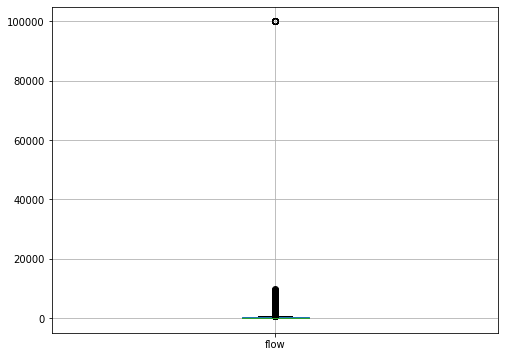

In [124]:
df.boxplot(column=['flow'])

In [125]:
bad_flow = df.loc[df['flow'] == 99999]
len(bad_flow)

31

Hay 31 mediciones con un valor erróneo para la columna `flow`: **Es necesario arreglar estos valores extremos!**

## Procesamiento del dataset

Algunos de los datos del dataset no interesan, bien porque su valor no es válido (`speed`) o bien porque
son simples identificadores (`_id` y `FID`). También se deberán formatear otras columnas:

In [126]:
df.pop('speed')
df.pop('FID')
df.pop('_id')

df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'datetime'], format='%Y-%m-%dT%H:%M:%S')

df['car_count'] = df.loc[:, 'flow'] // 12

# Ordena por fecha.
# ignore_index = True -> Pone los index del 0 al n-1 (todos por orden)
# inplace = True -> Para que ya lo haga sobre el df en vez de devolver el df ordenado
df.sort_values(by='datetime', ignore_index = True, inplace = True)

In [127]:
df

,sensor,flow,datetime,car_count
0,PM084,12,2019-10-01 00:00:00,1
1,PM059,0,2019-10-01 00:00:00,0
2,PM017,48,2019-10-01 00:00:00,4
3,PM052,0,2019-10-01 00:00:00,0
4,PM016,48,2019-10-01 00:00:00,4
...,...,...,...,...
2904405,PM039,0,2020-02-29 23:55:00,0
2904406,PM074,0,2020-02-29 23:55:00,0
2904407,PM075,0,2020-02-29 23:55:00,0
2904408,PM024,48,2020-02-29 23:55:00,4


Acciones realizadas:
1. La columna `speed` no aporta nada, todos su valores son -9999
2. La columna `FID` tampoco, es un identificador de cada medición, al igual que `_id`
3. La columna `datetime` tuvo que ser formateada para obtener un formato válido
4. La columna `flow` es útil, pero es más interesante conocer el número de vehículos que
 pasaron sobre el sensor en los últimos 5 minutos: `car_count`
5. Se han ordenado todas las entradas por el campo `datetime`

Seleccionemos 5 mediciones al azar:

In [128]:
df.sample(n=5)

,sensor,flow,datetime,car_count
2239358,PM065,60,2020-01-26 11:50:00,5
1940131,PM026,60,2020-01-12 06:00:00,5
1473381,PM049,180,2019-12-17 22:35:00,15
1025906,PM042,0,2019-11-26 03:20:00,0
2345499,PM011,60,2020-02-03 07:45:00,5


Veamos algunas estadísticas del conjunto de datos:

In [129]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
flow,2904410.0,148.064983,391.402798,0.0,0.0,48.0,228.0,99999.0
car_count,2904410.0,12.309273,32.616128,0.0,0.0,4.0,19.0,8333.0


Como ya se comentó en la sección anterior, existen 31 outlayers claros ( valor 99999.0 en la columna `flow`) que deben
ser eliminados:

In [130]:
df = df[df['flow'] != 99999.0]
df = df[df['car_count'] != 8333.25]

Podemos ver que ya no hay ninguna fila con `flow == 99999.0`:

In [131]:
bad_flow = df.loc[df['flow'] == 99999.0]
len(bad_flow)

0

Revisando de nuevo las estadísticas del dataset:

In [132]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
flow,2904379.0,146.999220,216.285009,0.0,0.0,48.0,228.0,9672.0
car_count,2904379.0,12.220462,18.023441,0.0,0.0,4.0,19.0,806.0


<AxesSubplot:>

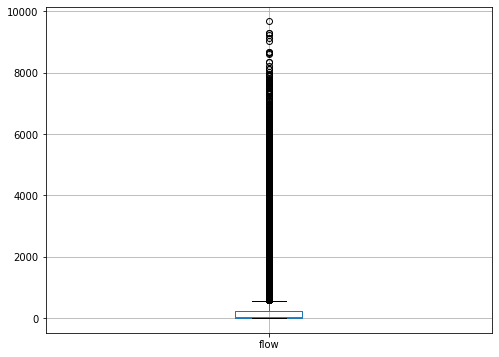

In [133]:
df.boxplot(column=['flow'])

A simple vista no se ven outlayers tan claros como anteriormente. Debido a que `flow` solo resulta de interés para
calcular `car_count`, esta característica puede ser eliminada ya del dataset.

In [134]:
df.pop('flow')

0          12
1           0
2          48
3           0
4          48
           ..
2904405     0
2904406     0
2904407     0
2904408    48
2904409     0
Name: flow, Length: 2904379, dtype: int64

## Experimentos planteados

Los experimentos a realizar consisten en predecir el tráfico en el punto en el que se ubica el
sensor `PM072` (CITIUS) en un instante `t` a partir de las mediciones realizadas por otros
sensores en un instante `t-x`. Los experimentos contemplados son los siguientes:

1. Predecir en `PM072` a partir de:
    - `PM029` (Entrada túnel Romero Donallo)
    - **No es posible, ya que ese sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)

2. Predecir en `PM072` a partir de:
    - `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
    - `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
    - `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - **No es posible, ya que ese sensor estaba averiado** -`PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

3. Predecir en `PM072` a partir de:
    - `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
    - `PM076` (Rúa do Horreo - Rotonda Galuresa)
    - `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
    - `PM079` (Rúa do Horreo - Rotonda Galuresa)

4. Predecir en `PM072` a partir de:
    - Todos los sensores disponibles

Para cada uno de los experimentos anteriormente citados se llevará a cabo la implementación del modelo con:
* Perceptrón multicapa
* Red Neuronal Convolucional (CNN)
* Red Neuronal Recurrente (RNN)

Asimismo, se deberá realizar un análisis de la varianza y bias para cada experimento
(Ver 6 primeras semanas Machine Learning Stanford: https://www.coursera.org/learn/machine-learning)

Por otra parte, también se probarán diversas formas de incluir las marcas temporales (timestamps) en el modelo:
* Día de la semana (1-7) y hora del día (minutos)
* Día de la semana y hora del día *modelado con sin y cos*
* Ventanas temporales (¿?)

## Experimento #1

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #1** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
* `PM029` (Entrada túnel Romero Donallo)
* **No es posible, ya que es sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)


### Análisis dataset Experimento #1
`
En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [135]:
sensors_list = ['PM029', 'PM072']
df_1 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [136]:
df_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
car_count,78690.0,16.797547,14.859483,0.0,4.0,13.0,26.0,92.0


Veamos un boxplot:

<AxesSubplot:>

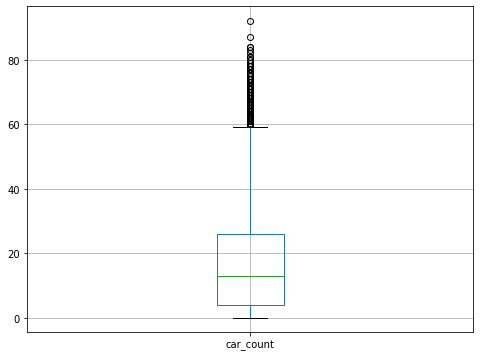

In [137]:
df_1.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`. Hay que tener en cuenta que los datos
que se encuentran fuera de la caja o de los brazos de la misma, no pueden ser considerados outlayers automáticamente.
Al tratarse de mediciones de tráfico, es evidente que a ciertas horas del día (principalmente de madrugada), el número de
coches registrado suele ser muy bajo incluso 0, por lo que la media y los cuartiles se encuentran afectados por estas
medicones.

### Análisis gráfico Experimento #1

Para ver la evolución de los datos del tráfico de manera más intuitiva se realizarán una serie de representaciones
gráficas.

La siguiente función recibe un dataframe, una lista de días y el nombre de un sensor. Grafica todas las mediciones
realizadas por ese sensor (agregados de 5 minutos) a lo largo de los días indicados

In [138]:
def plot_sensors_daily_data(df_orig, days_list, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    fig, axs = plt.subplots(days_list.shape[0])
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y = df.loc[(df['datetime'] >= days_list[i]) & (df['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        axs[i].plot(x, y)

        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 100, 20))
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))
        axs[i].grid()

Podemos probar a pasarle los 7 días de una semana para ver como evoluciona el tráfico que pasa
por ese sensor durante esa semana:

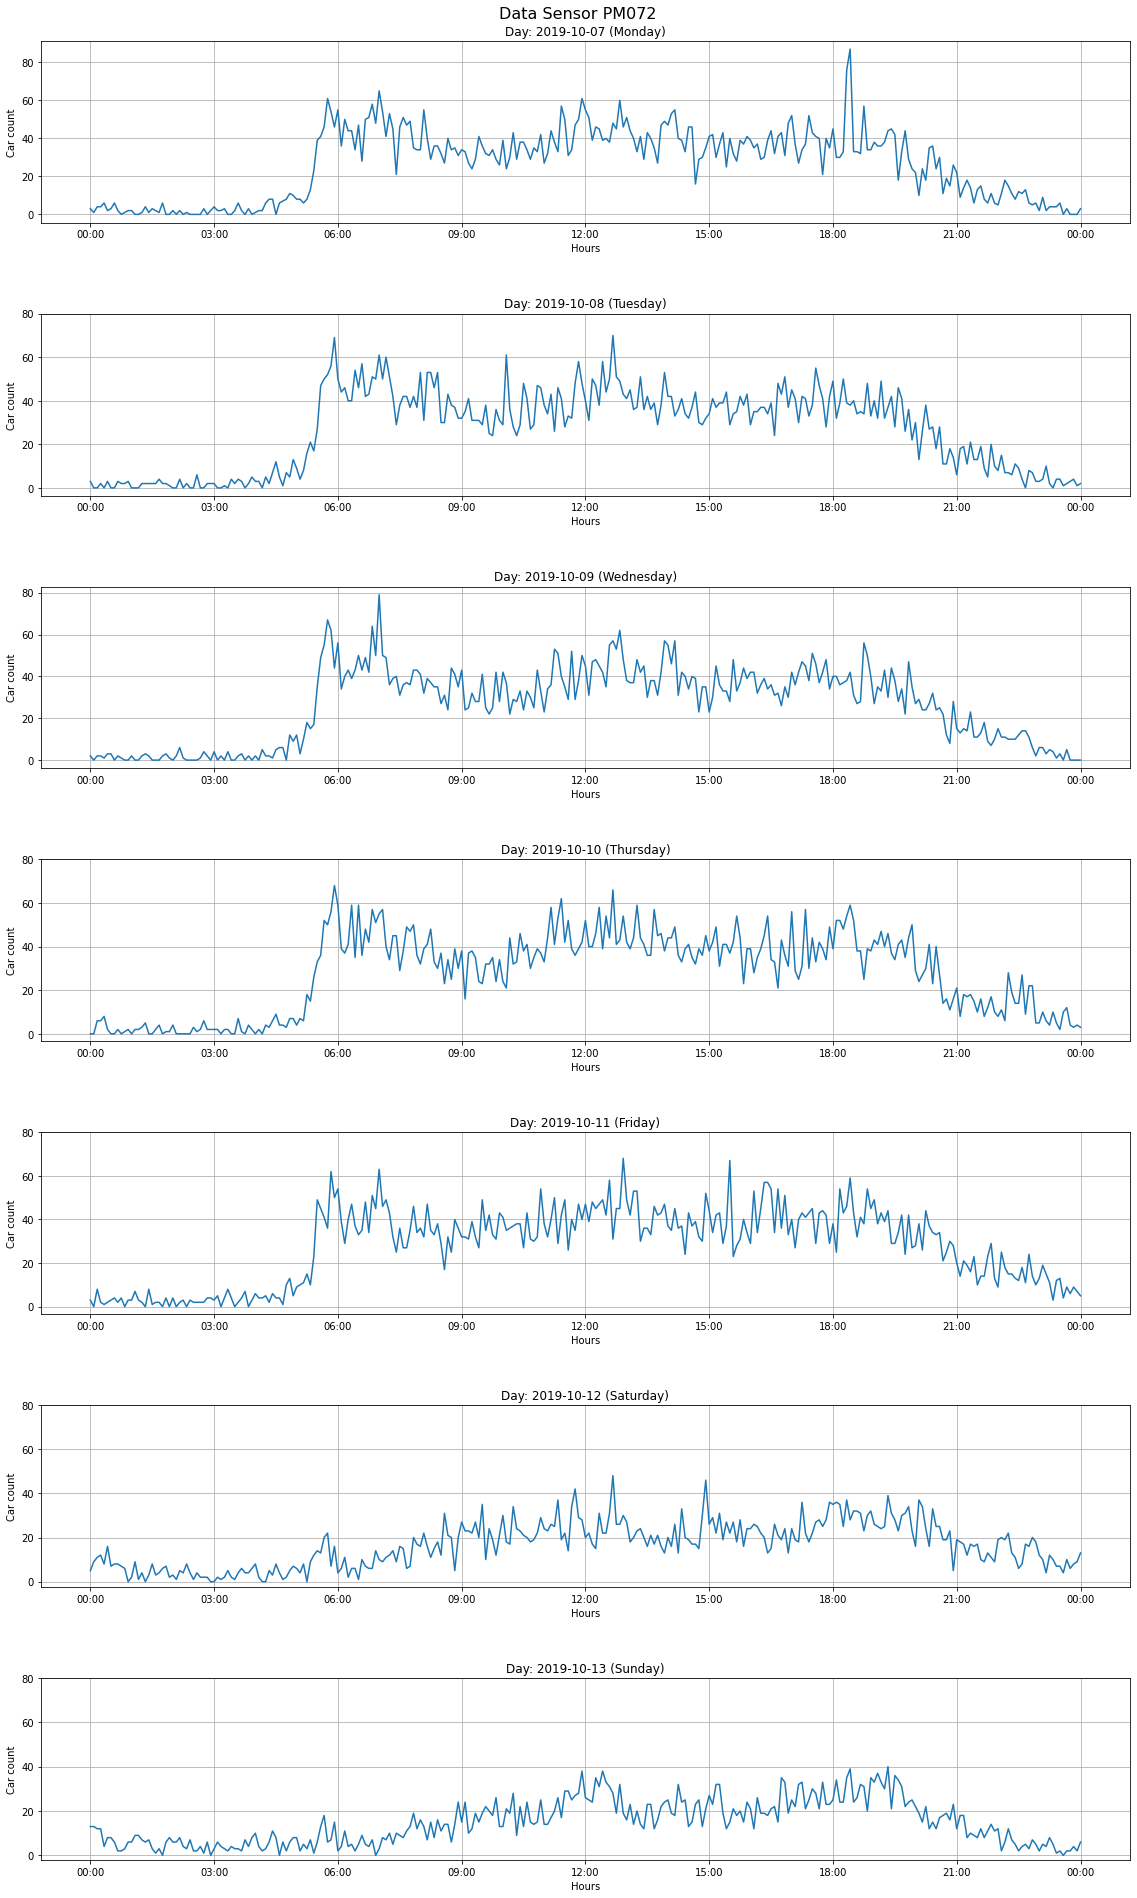

In [139]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

También podemos graficar los lunes (o cualquier día de la semana: W-SUN, W-FRI) que hubo en un mes:

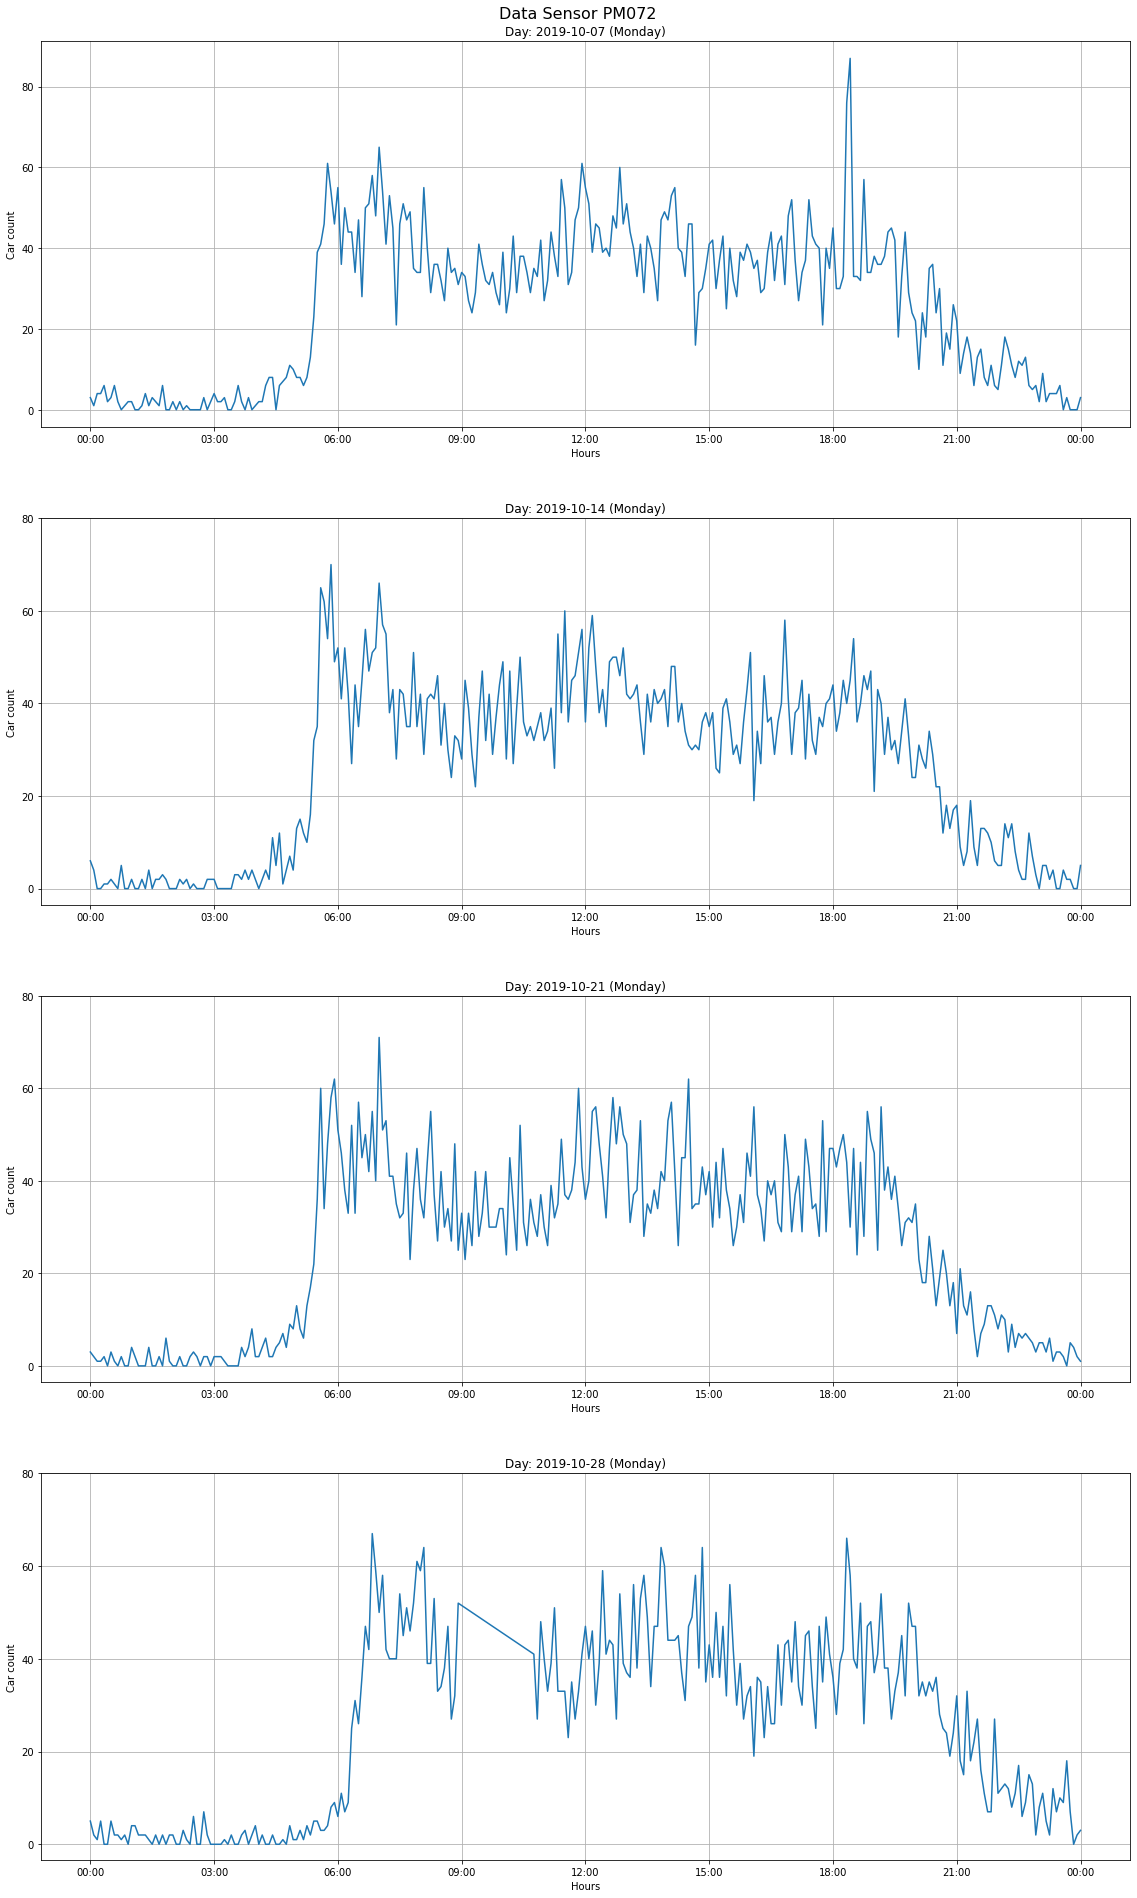

In [140]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

Las gráficas anteriores tienen mucho ruido, aunque resultan útiles para hacer una comprobación de outlayers.
Sin embargo, para ver de una manera más directa si existe periodicidad en el tráfico es más interesante **representar
los datos con agregados superiores a 5 minutos**

La siguiente función recibe un dataframe, una lista de días, un valor `n` que indica el número de mediciones agregadas,
y el nombre de un sensor. Grafica la media (mean) y desviación típica (std) de las mediciones realizadas durante el sensor
durante esos días en **agregados de 5*n minutos**

In [141]:
def plot_sensors_agregated_daily_data(df_orig, days_list, n, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    # Dataframe con los agregados
    df_mean = pd.DataFrame(columns=df.columns)
    df_std = pd.DataFrame(columns=df.columns)

    for g, df_slice in df.groupby(np.arange(len(df)) // n):
        mean_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].mean()}
        df_mean = df_mean.append(mean_row, ignore_index=True)

        std_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].std()}
        df_std = df_std.append(std_row, ignore_index=True)

    fig, axs = plt.subplots(days_list.shape[0])
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y_mean = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']
        y_std = df_std.loc[(df_std['datetime'] >= days_list[i]) & (df_std['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        axs[i].plot(x, y_mean, label='mean')
        axs[i].plot(x, y_std, label='std')

        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 100, 20))
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))
        axs[i].legend(loc='upper left')
        axs[i].grid()


Veamos la evolución del tráfico (media y desviación típica) durante una semana con agregados de 30 minutos (5*6)

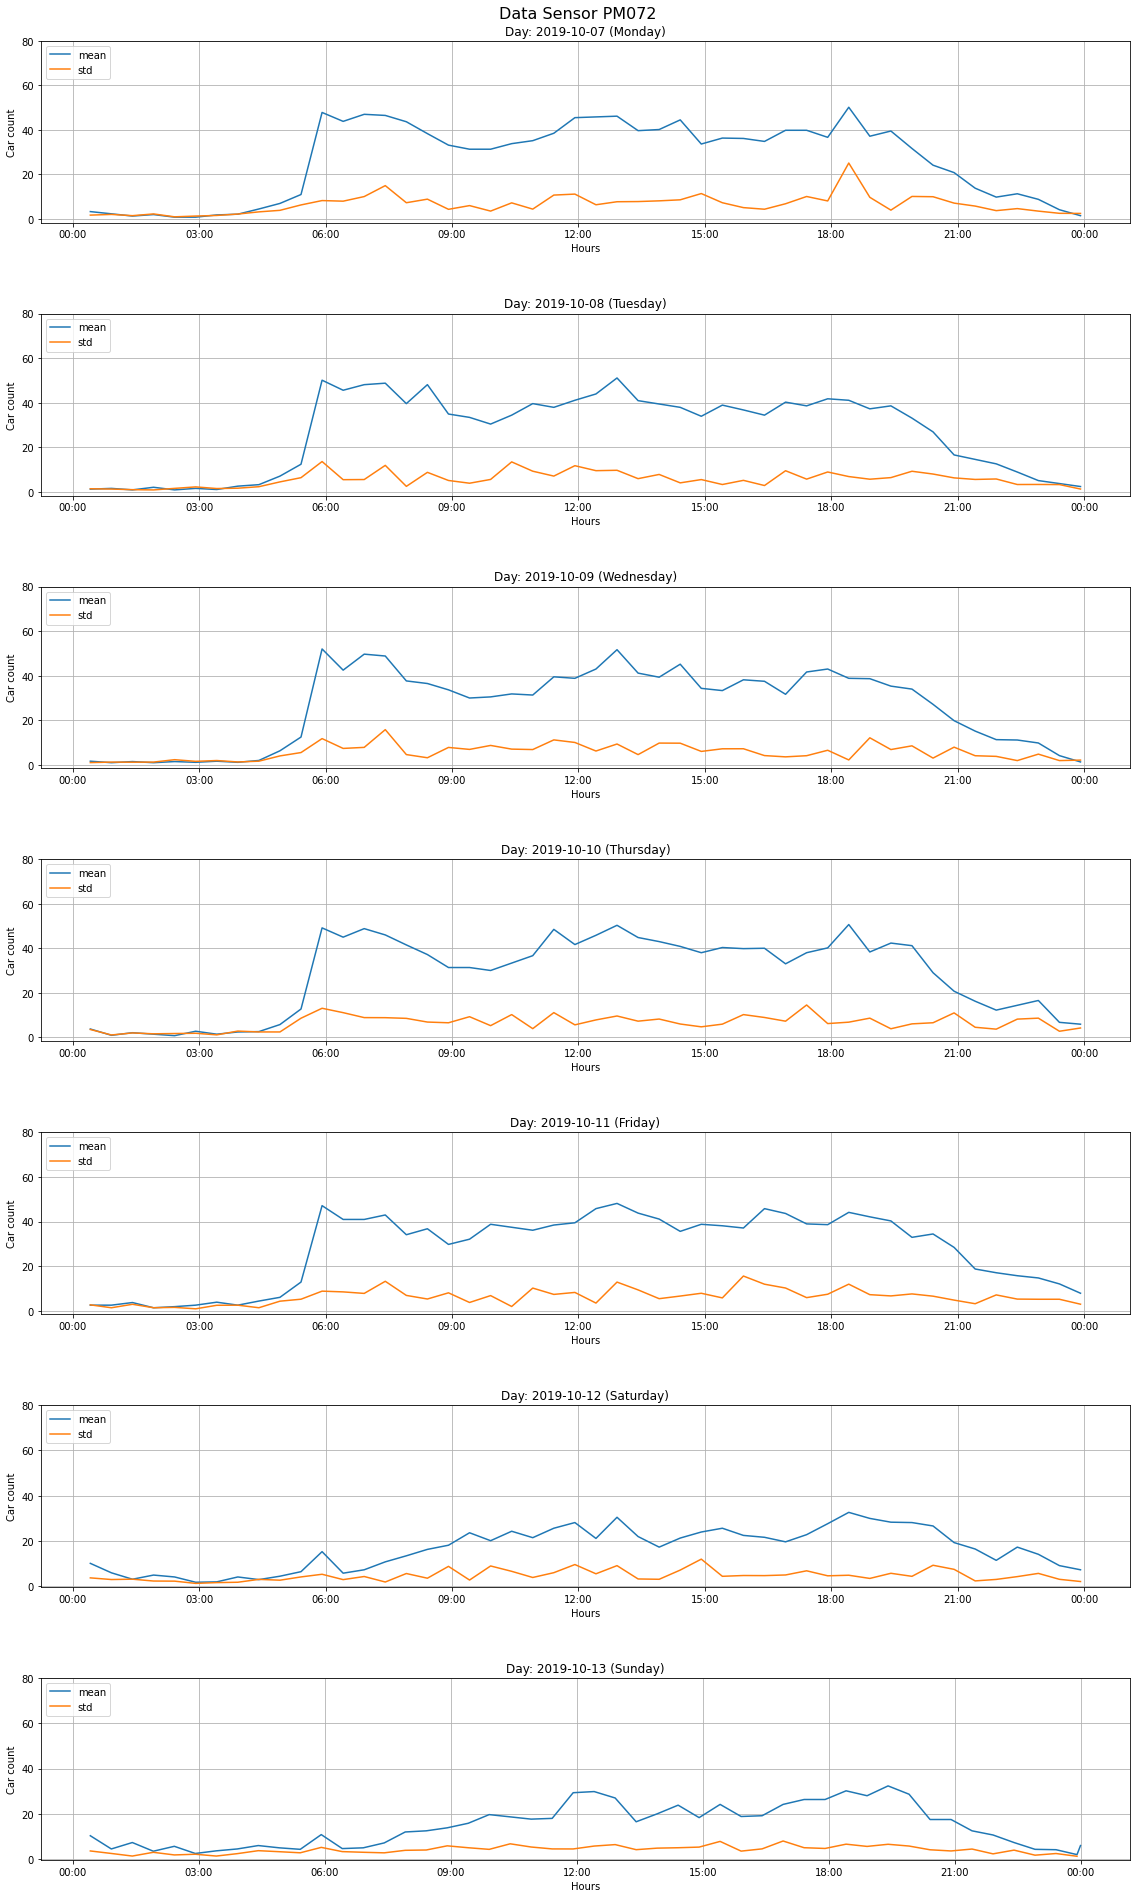

In [142]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')

Veamos la evolución del tráfico durante los lunes de un mes con agregados de 30 minutos (5*6)

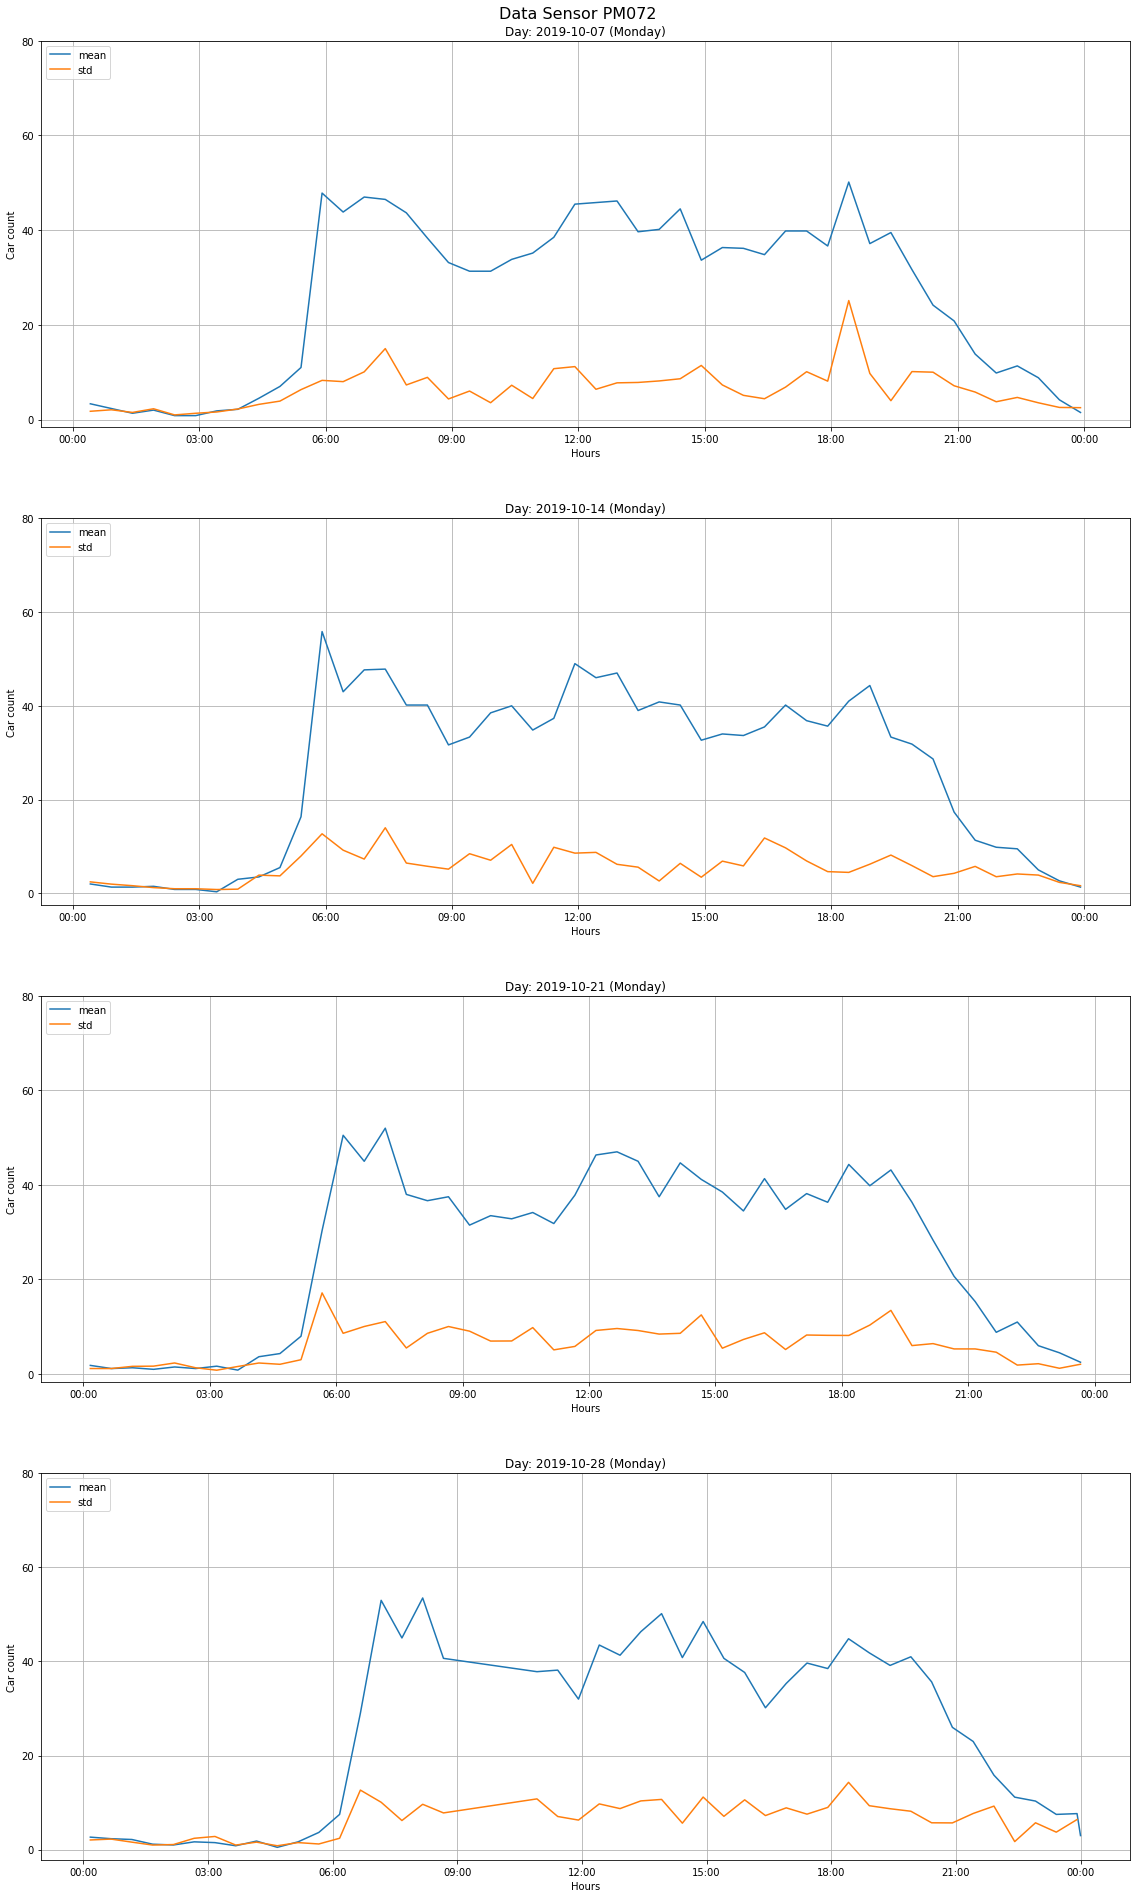

In [143]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')

### Preparación dataset Experimento #1

#### Label PM072

El objetivo del Experimento #1 e predecir el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS)
en un instante `t` a partir de las mediciones realizadas en un instante `t-x` por el sensor `PM029`.

A cualquier modelo es necesario pasarle un vector de características con el que pueda trabajar. En este caso, el vector
de características tiene la siguiente forma:

In [144]:
column_names = ['datetime', 'car_count_PM029', 'label_PM072']
pd.DataFrame(columns = column_names)

,datetime,car_count_PM029,label_PM072


Es decir, para cada instante temporal (`datetime`) que hay en el dataset, debe haber un vector de características que
contenga dicho instante temporal y el valor medido por los sensores que se usarán para predecir. Asimismo, también debe
contener el valor medido por el sensor `PM072` `x minutos` después.

Los sensores pueden fallar o detenerse por labores de mantenimiento, por lo que es posible que en algún instante temporal
uno de los sensores tome una medición y otro no, quedando así el vector de características incompleto. Esto no puede
permitirse, por lo que **si falta una medición de un sensor para un determinado instante temporal, todas las mediciones
correspondientes a dicho instante deben ser eliminadas.**

Para facilitar la preparación del dataset se ha creado la siguiente función. Recibe el dataset original, la lista de sensores
que se usarán para predecir, el sensor en el que se quiere predecir y los `x minutos` de desfase temporal.


In [145]:
def prepare_df(df_orig, sensors_list, label_sensor, x):

    # Instante temporal y car_count de dicho sensor
    prepared_df = df_orig.loc[ df_orig['sensor'] == sensors_list[0] , ['datetime', 'car_count']]
    # Renombrar la columna car_count
    prepared_df.rename(columns={'car_count': 'car_count_' + sensors_list[0]}, inplace=True)

    # MERGE no tiene en cuenta los index. Los reinicia y los pone del 0 al n-1 (todos en orden)
    # INNER JOIN con los datos de cada sensor de la lista (sin contar el primero),
    # asi evito el problema de que falten mediciones de algunos sensores en un determinado instante temporal
    for ss in sensors_list[1:]:
        aux = df_orig.loc[ df_orig['sensor'] == ss, ['datetime', 'car_count']]
        aux.rename(columns={'car_count': 'car_count_' + ss}, inplace=True)
        prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    # Obtengo los datos del sensor a predecir x minutos despues
    aux = df_orig.loc[ df_orig['sensor'] == label_sensor, ['datetime', 'car_count']]
    # Resto los x minutos de para poder hacer el JOIN y MANTENIENDO EL CAR_COUNT que interesa
    aux['datetime'] = aux['datetime'] - datetime.timedelta(minutes=x)
    aux.rename(columns={'car_count': 'label_' + label_sensor}, inplace=True)
    prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    return prepared_df

A continuación, se utiliza la función para preparar el dataset para el Experimento #1:

In [146]:
sensors_list = ['PM029']
df_1 = prepare_df(df_1, sensors_list, label_sensor='PM072', x = 5)

In [147]:
df_1

,datetime,car_count_PM029,label_PM072
0,2019-10-01 00:00:00,1,0
1,2019-10-01 00:05:00,0,0
2,2019-10-01 00:10:00,0,0
3,2019-10-01 00:15:00,0,0
4,2019-10-01 00:20:00,0,1
...,...,...,...
38784,2020-02-29 23:30:00,4,8
38785,2020-02-29 23:35:00,0,7
38786,2020-02-29 23:40:00,3,11
38787,2020-02-29 23:45:00,3,22


**El `df_1` está ordenado por fecha y los Index van del 0 al n-1 (todos en orden)**

#### Tiempo

Antes de construir un modelo es importante entender los datos con los que se trabaja y estar seguro que los datos
que se le pasan al modelo está correctamente formateados.

Observando ls gráficas anteriores se puede observar claramente que el tráfico tiene un comportamiento
cíclico según la *hora del día* y del *día de la semana*. Es decir, el tráfico de cada lunes durante todas las horas
del día es muy similar. A continuación se codificará este comportamiento:

#### Horas del día

Una de las formas más comunes para representar características cíclicas es mediante el uso de la función seno y la función
coseno [REFERENCIA]. En primer lugar, es necesario recuperar las horas y minutos de las fechas y convertirlo en segundos (o en minutos):

In [148]:
date_time = pd.to_timedelta(df_1['datetime'].dt.strftime('%H:%M:%S'))
date_time_s = date_time.dt.total_seconds().astype(int)

El tiempo en segundos no resulta muy útil como input para el modelo. Está claro que la periodicidad del tráfico es diaria.

Para convertir el tiempo en una señal usable se puede usar el seno y el coseno:

In [149]:
seconds_in_day = 24*60*60
df_1['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
df_1['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

De esta manera se logra modelar las horas como en un reloj, las 00h y están a continuación de las 23h.

La gráfica correspondiente al primer día del dataset es la siguiente ([:288] porque cada hora hay 12 mediciones * 24h = 288):

Text(0.5, 1.0, 'Time of day signal')

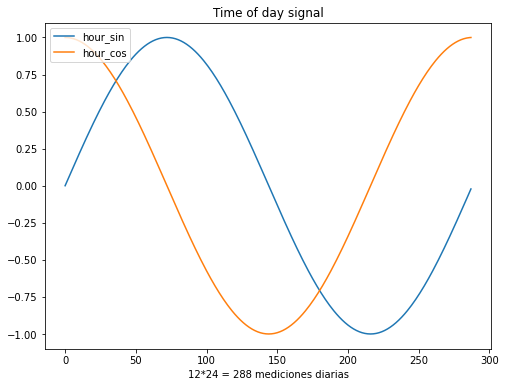

In [150]:
plt.plot(df_1[ 'hour_sin'][:288], label = 'hour_sin')
plt.plot(df_1['hour_cos'][:288], label = 'hour_cos')
plt.legend(loc='upper left')
plt.xlabel('12*24 = 288 mediciones diarias')
plt.title('Time of day signal')

Si solamente se observa la función seno, al trazar una línea horizontal se cruza en dos puntos, por lo que sólo teniendo
en cuenta esta característica, las 00:00h y las 12:00h son lo mismo. Para solucionar esto se toma en consideración el coseno, con ambas
características ya es posible distinguir esas horas y todo codificado de manera cíclica.

Una forma más intuitiva de ver lo que acabamos de hacer es representar ambas características como si se tratase un reloj:

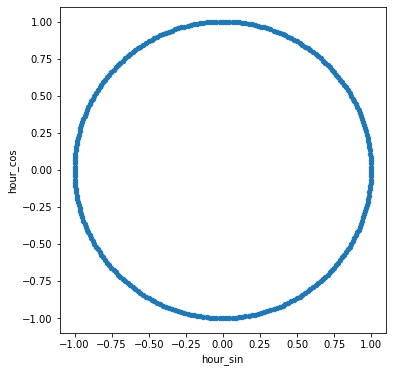

In [151]:
df_1[:288].plot.scatter('hour_sin','hour_cos').set_aspect('equal');

**Comentario personal:** Fíjate en las tablas a continuación que, evidentemente,
hour_sin` y  `hour_cos` son iguales para 2019-10-01 00:00:00 y 2019-10-02 00:00:00.
Como nos interesa que también se tenga en cuenta el día de la semana tenemos que hacer algo más!!

In [152]:
df_1[:2]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos
0,2019-10-01 00:00:00,1,0,0.000000,1.000000
1,2019-10-01 00:05:00,0,0,0.021815,0.999762


In [153]:
df_1[288:290]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos
288,2019-10-02 00:00:00,1,2,0.000000,1.000000
289,2019-10-02 00:05:00,1,4,0.021815,0.999762


#### Días de la semana

Tal y como hemos visto en las gráficas durante el `Análisis gráfico`, el tráfico tiene una clara frecuencia semanal.
Se puede ver cómo las gráficas de cada uno de los lunes (por ejemplo) son muy similares. Esto es algo que nos interesa
que nuestro modelo conozca, por lo que tenemos que realizar un trabajo similar al que hemos realizado con las horas.
*Los días de la semana también son cíclicos!*

In [154]:
wday = df_1['datetime'].dt.weekday
days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
df_1['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
df_1['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

Nuevamente, en una representación circular, vemos los 7 días de la semana:

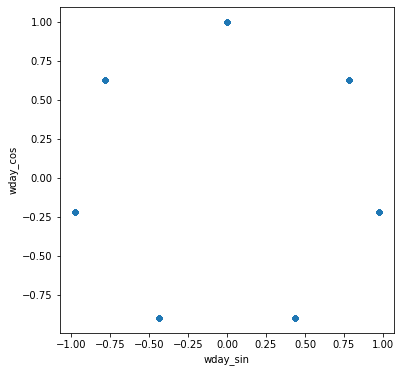

In [155]:
df_1.plot.scatter('wday_sin','wday_cos').set_aspect('equal');

**Comentario personal:** Cada uno de los 7 puntos que vemos contiene 288 puntos (hay 288 mediciones cada día).
En la siguiente tabla podemos ver como cada día de la semana (del 0 al 6) tiene un `wday_sin` y `wday_cos` diferente!!

In [156]:
df_1[0:2000:288]

,datetime,car_count_PM029,label_PM072,hour_sin,hour_cos,wday_sin,wday_cos
0,2019-10-01 00:00:00,1,0,0.000000,1.000000,0.781831,0.623490
288,2019-10-02 00:00:00,1,2,0.000000,1.000000,0.974928,-0.222521
576,2019-10-03 00:00:00,0,1,0.000000,1.000000,0.433884,-0.900969
864,2019-10-04 13:50:00,18,50,-0.461749,-0.887011,-0.433884,-0.900969
1152,2019-10-05 13:50:00,5,15,-0.461749,-0.887011,-0.974928,-0.222521
1440,2019-10-06 13:50:00,10,12,-0.461749,-0.887011,-0.781831,0.623490
1728,2019-10-07 13:50:00,17,49,-0.461749,-0.887011,0.000000,1.000000


#### Características auxiliares/extra

Durante la preparación se utilizaron/crearon columnas extra en el dataset que no aportarán nada a nuestro modelo.
Estas deben ser eliminadas antes del entrenamiento.

(Se mantienen para facilitar la graficación posterior)

#### Dataset final para Experimento #1

Finalmente el dataset contiene:
1. `datetime`: Fecha y hora de la medición
2. `car_count_PM029`: Número de coches que pasaron por el sensor en los últimos 5 minutos
3. `label_PM072`: El dato a predecir
4. `hour_sin` y `hour_cos`: Hora del día codificada
5. `wday_sin` y `wday_cos`: Día de la semana codificado


Para facilitar los siguientes experimentos se ha creado la función `encode_time_sin_cos`, que hará lo comentado anteriormente:

In [157]:
def encode_time_sin_cos(enc_df):

    date_time = pd.to_timedelta(enc_df['datetime'].dt.strftime('%H:%M:%S'))
    date_time_s = date_time.dt.total_seconds().astype(int)

    seconds_in_day = 24*60*60
    enc_df['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
    enc_df['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

    wday = enc_df['datetime'].dt.weekday
    days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
    enc_df['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
    enc_df['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

    # Se mantiene para graficar más tarde, debe ser eliminado antes de entrenar
    #enc_df.pop('datetime')

    return enc_df

def encode_time(enc_df):

    enc_df['week_day'] = enc_df['datetime'].dt.weekday
    enc_df['hour'] = enc_df['datetime'].dt.hour
    enc_df['min'] = enc_df['datetime'].dt.minute

    enc_df.pop('datetime')

    return enc_df

### Implementación Perceptrón Multicapa (MLP)

#### Definición Perceptrón Multicapa (MLP)

Está en el fichero MLP_Metodología.txt y en la Memoria

#### Implementación Perceptrón Multicapa (MLP)

#### División del dataset

Es necesario dividir el dataset en los conjuntos de:
* Entrenamiento: `90%`
* Validación: `10%` (Dentro del de Entrenamiento)
* Test: `10%`

**Para evitar problemas con la distribución de las mediciones es necesario hacer un `shuffle`
(reordenamiento aleatorio del dataset) antes de dividirlo.**

In [158]:
# Shuffle
df_1_shuffled=df_1.sample(frac=1).reset_index(drop=True)

n = len(df_1)
train_df_1 = df_1_shuffled[0:int(n*0.90)]
test_df_1 = df_1_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1.pop('datetime')
test_dates = test_df_1.pop('datetime')

#### Separación de las 'features' y 'labels'

Debemos separar las características del dato a predecir (`label_PM072`) en ambos conjuntos:

In [159]:
train_labels = train_df_1.pop('label_PM072')
train_features = train_df_1

test_labels = test_df_1.pop('label_PM072')
test_features = test_df_1

#### Normalización de los datos

Normalizar los datos es un paso importante para lograr un buen modelo, ya que
ayuda a que el descenso de gradiente pueda converger de manera más rápida.

La normalización debe realizarse tras la `División del dataset` y **utilizando solamente los datos de conjunto
de entrenamiento.** Esto de sebe a que el conjunto de test juega el papel de datos que aún no han sido vistos,
usar información procedente de estos datos para la normalización de todo el conjunto daría lugar a un *sesgo*
durante la evaluación del desempeño del modelo.

In [160]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [103]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(history)

In [162]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

122/122 - 0s - loss: 44.0695 - mae: 4.8680
Loss (MSE):  44.06950759887695
MAE:  4.8680419921875


Tras haber realizado múltiples pruebas con las distintas arquitecturas e hiperparámetros, se ha llegado
a un modelo *vencedor*.

El MSE es una medida difícil de interpretar, ya que no está en las mismas unidades
que el problema. Por otra parte, el MAE es más fácil de interpretar, ya que este sí está en las mismas unidades.
Sin embargo, **este valor no es representativo.**

Tal y como se pudo observar en las gráficas del comienzo del trabajo,
hay determinadas horas del día en las que el número de coches es más bajo o más alto. Por ejemplo, entre las 00:00
y las 06:00 el número de coches es muy bajo, entre 5 y 10 (GENERALMENTE), mientras que en la franja de 06:00 a 18:00 
varía entre 30 y 50.

Decir que hay un error medio de 5 coches cuando pasan 60 coches es viable, no así si ese error se
da cuando pasan tan solo 2.

Para poder visualizar y comprender mejor la calidad del modelo se hará una representación gráfica a partir de los
resultados obtenidos en las predicciones con el conjunto de test. La siguiente función muestra una gráfica para cada
día de la semana en la que aparecen los datos reales y los predichos por el modelo.

**NOTA:** Cada gráfica contiene los resultados de un determinado día de la semana (p.ej, Lunes), pero ese día de la semana
puede corresponder a semanas/meses diferentes. Esto se hace para ver una representación más general, ya que no tendría
sentido representar las predicciones de cada fecha exacta.

El parámetro `freq` regula la cantidad de puntos que aparecen en cada gráfica. Se cojen puntos espaciados `freq` unidades.
Con `freq=1` se representan todos los puntos; sin embargo, resulta complicado observar 500 puntos por gráfica.

In [163]:
def graph_predictions(test_dts, test_lbls, preds, freq):
    # Como el conjunto de test es la parte final del conjunto general DESPUES DEL SHUFFLE,
    # los indices empiezan en torno al 34 mil. Es mejor ponerlos a 0 para evitar problemas!
    test_dts.reset_index(inplace=True, drop=True)
    test_lbls.reset_index(inplace=True, drop=True)

    # Concateno las fechas, los labels y las predicciones en el mismo df
    cc_df = pd.concat([test_dts, test_lbls], axis=1)
    cc_df = pd.concat([cc_df, preds], axis=1)

    ############################ LÓGICA INTERESANTE ############################################
    # Necesito representar en el eje x las horas pero de días diferentes. Antes pasaba SOLO
    # la hora a String y usaba eso, pero daba problemas. Ahora recupero la hora de cada fecha
    # y se la sumo al día de hoy a las 00:00. De esta manera tengo todas las horas de todas las
    # fechas, pero en el día de hoy!!

    # Obtengo solo la hora de cada fecha
    hours = cc_df['datetime'].dt.strftime('%H:%M:%S')
    # Convierto las horas a timedelta y se las sumo al día de hoy a las 00:00
    cc_df['hour'] = pd.to_datetime(pd.to_timedelta(hours) + pd.to_datetime('today').normalize())
    ############################################################################################

    # Obtengo el dia de la semana [0-Lunes, 6-Domingo]
    cc_df['wday'] = cc_df['datetime'].dt.weekday
    # Ordeno por 'wday' y luego por 'hour' -> No es necesario
    cc_df.sort_values(by=['wday', 'hour'], ignore_index = True, inplace = True)

    # Settings
    fig, axs = plt.subplots(7)
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Labels vs. Predictions', fontsize=16)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Gráfica para cada día de la semana
    for i in range(7):
        # DataFrame para cada día de la semana
        aux = cc_df.loc[cc_df['wday'] == i]

        # Para una determinada hora puede haber varios label y predicciones (#label == #preds)
        axs[i].scatter(aux['hour'][::freq], aux['label_PM072'][::freq], label='Labels', s=12)
        axs[i].scatter(aux['hour'][::freq], aux['prediction'][::freq], label='Predictions', s=12)

        # Más settings
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 90, 10))
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title(day_names[i])

        axs[i].legend(loc='upper left')
        axs[i].grid()

    return cc_df

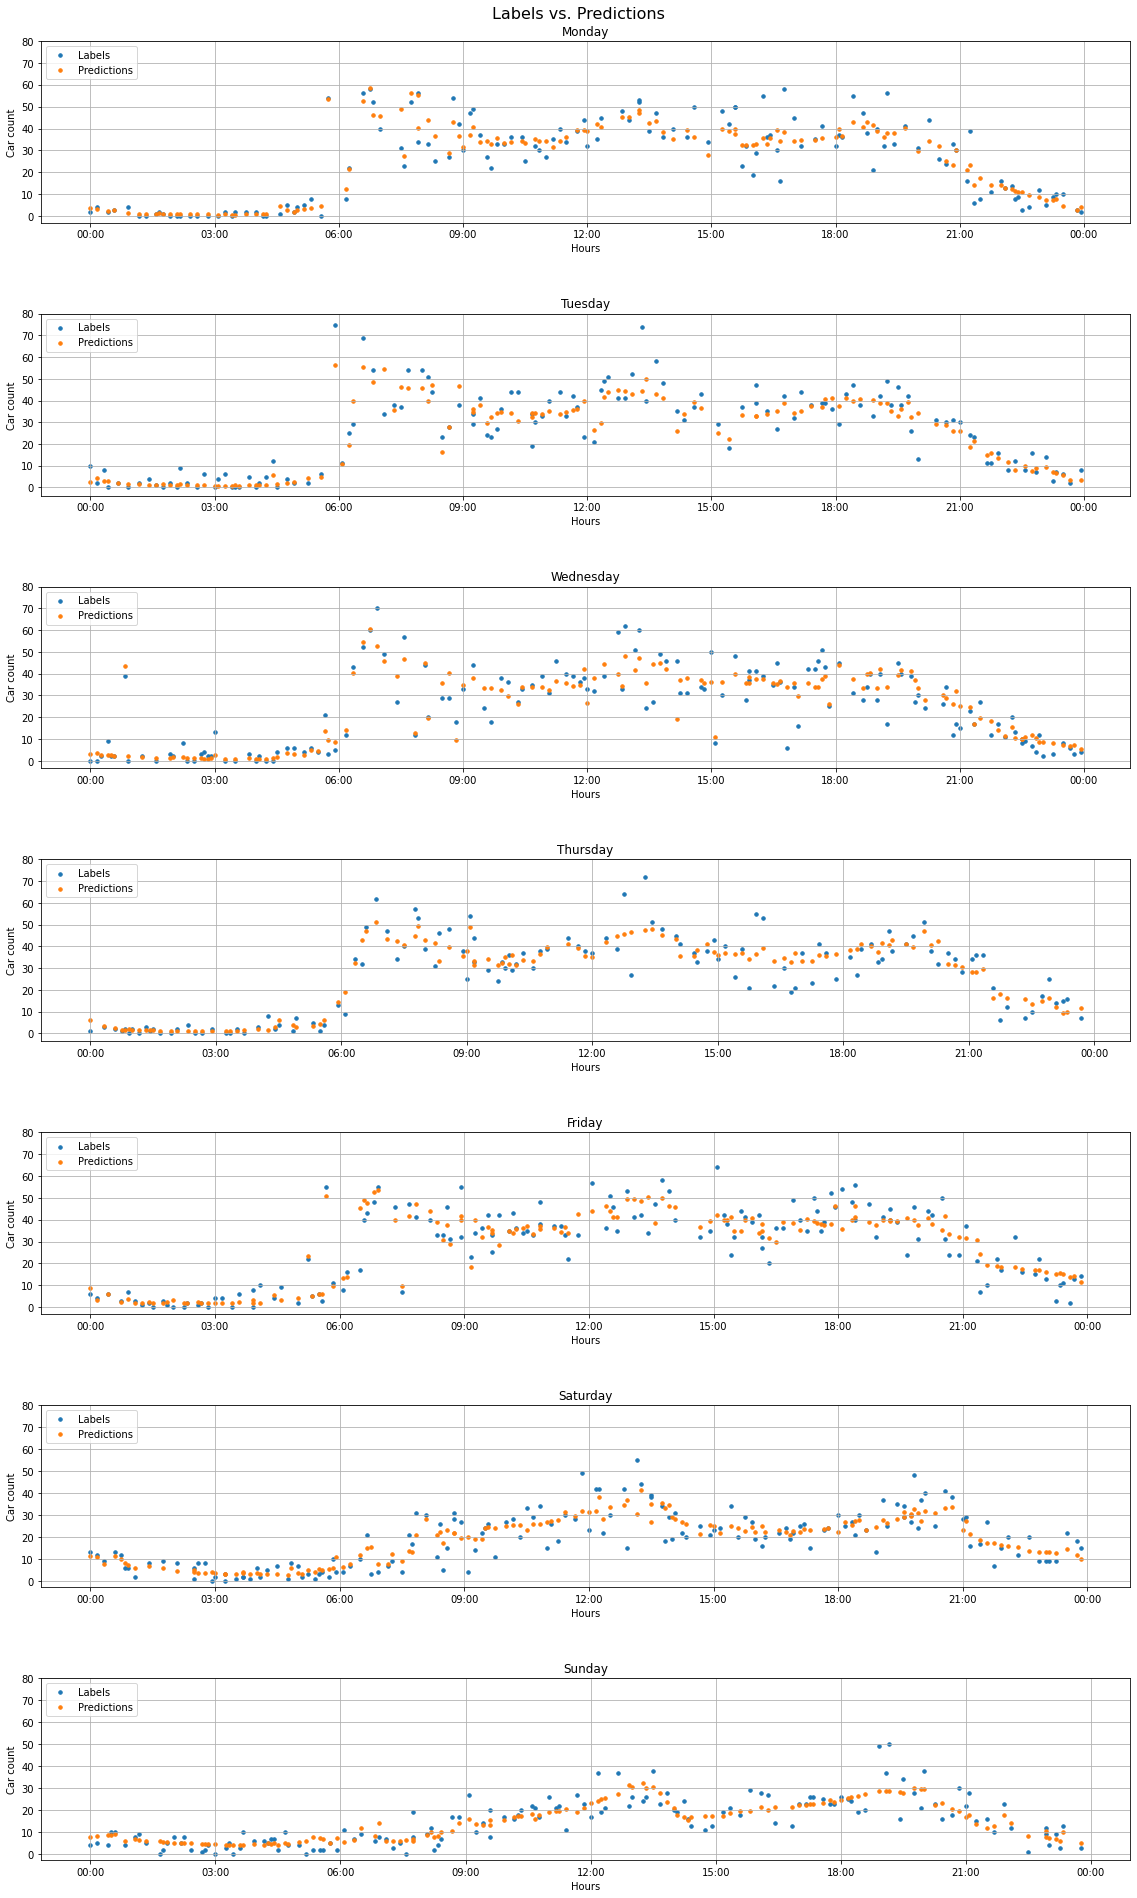

In [164]:
check_values = graph_predictions(test_dates, test_labels, predictions, freq = 4)

Para comprobar algunos valores que puedan parecer atípicos se utiliza la siguiente linea:

In [165]:
h_inicio = pd.to_timedelta('00:00:00') + pd.to_datetime('today').normalize()
h_fin = pd.to_timedelta('00:20:00') + pd.to_datetime('today').normalize()
check_values.loc[ (check_values['wday'] == 6) & (check_values['hour'] > h_inicio) & (check_values['hour'] < h_fin) ]

,datetime,label_PM072,prediction,hour,wday
3315,2020-02-16 00:05:00,18,6.082229,2021-04-30 00:05:00,6
3316,2019-12-15 00:05:00,13,8.569969,2021-04-30 00:05:00,6
3317,2020-02-02 00:10:00,5,8.490066,2021-04-30 00:10:00,6
3318,2019-12-08 00:15:00,3,8.909552,2021-04-30 00:15:00,6


También resulta interesante ver una gráfica del error que se comete y la media de los errores relativos:

In [166]:
def graph_errors(test_dts, test_lbls, preds, freq):
    # Como el conjunto de test es la parte final del conjunto general DESPUES DEL SHUFFLE,
    # los indices empiezan en torno al 34 mil. Es mejor ponerlos a 0 para evitar problemas!
    test_dts.reset_index(inplace=True, drop=True)
    test_lbls.reset_index(inplace=True, drop=True)

    # Concateno las fechas, los labels y las predicciones en el mismo df
    cc_df = pd.concat([test_dts, test_lbls], axis=1)
    cc_df = pd.concat([cc_df, preds], axis=1)

    ############################ LÓGICA INTERESANTE ############################################
    # Obtengo solo la hora de cada fecha
    hours = cc_df['datetime'].dt.strftime('%H:%M:%S')
    # Convierto las horas a timedelta y se las sumo al día de hoy a las 00:00
    cc_df['hour'] = pd.to_datetime(pd.to_timedelta(hours) + pd.to_datetime('today').normalize())
    ############################################################################################

    # Obtengo el dia de la semana [0-Lunes, 6-Domingo]
    cc_df['wday'] = cc_df['datetime'].dt.weekday
    # Ordeno por 'wday' y luego por 'hour' -> No es necesario
    cc_df.sort_values(by=['wday', 'hour'], ignore_index = True, inplace = True)

    # Calculo el error absoluto en cada medición-predicción
    cc_df['abs_error'] = (cc_df['label_PM072']-cc_df['prediction']).abs()
    # Calculo el error relativo en cada medición-predicción
    cc_df['rel_error'] = (cc_df['abs_error']/cc_df['label_PM072']).round(2)
    # Categoría para el error
    cc_df['category'] = pd.cut(cc_df['rel_error'], [-np.inf, 0.10, 0.20, 0.30, np.inf], labels=['< 10%', '10-20%', '20-30%', '> 30%'])

    # Settings
    fig, axs = plt.subplots(7)
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Absolute Error on Each Prediction', fontsize=16)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    colors = {'< 10%':'green', '10-20%':'blue', '20-30%':'orange', '> 30%':'red'}

    # Gráfica para cada día de la semana
    for i in range(7):
        # DataFrame para cada día de la semana
        aux = cc_df.loc[cc_df['wday'] == i]

        # Asigna el color según ka categoría
        axs[i].scatter(aux['hour'][::freq], aux['abs_error'][::freq], c=aux['category'][::freq].map(colors), s=15)

        # Más settings
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 35, 5))
        axs[i].set(xlabel='Hours', ylabel='Absolute Error')
        axs[i].set_title(day_names[i])

        # Leyenda personalizada
        legend_labels = [(mlines.Line2D([], [], color=value, marker='o', ls='', label=key)) for key, value in colors.items()]
        axs[i].legend(handles=legend_labels, loc='upper left', title = "Relative Error")
        axs[i].grid()


    ########################### DATOS 6:00 a 21:00 ###############################
    h_inicio = pd.to_timedelta('06:00:00') + pd.to_datetime('today').normalize()
    h_fin = pd.to_timedelta('21:00:00') + pd.to_datetime('today').normalize()
    day_df = cc_df.loc[(cc_df['hour'] >= h_inicio) & (cc_df['hour'] <= h_fin)]

    # Fuera los inf
    day_df = day_df.copy(deep = True)
    day_df.replace(to_replace = [np.inf, -np.inf], value = np.nan, inplace = True)
    day_df.dropna(inplace = True)

    # Por si elimino los errores > 100%
    #day_df = day_df[rel_err < 1.0]

    ########################### GRÁFICA ACCUM VS. ABS_ERROR ######################
    fig, ax = plt.subplots()

    x = np.arange(0, 36, 1) # 0..35
    accum_perc = []
    for i in x:
        perc = (len(day_df.loc[ day_df['abs_error'] <= i ])/len(day_df)) * 100
        accum_perc.append(perc)

    ax.plot(x, accum_perc, linestyle='-', c='blue')
    pts = np.arange(5, 15, 5)
    pts_color = ['orange', 'red']
    for i in range(len(pts)):
        ax.plot(x[pts[i]], accum_perc[pts[i]], c = pts_color[i], marker = 'o', markersize = 6, label = 'Abs Error < ' + str(pts[i]))
        ax.text(x[pts[i]]+1, accum_perc[pts[i]], s = str(round(accum_perc[pts[i]], 2)), fontsize=12)

    ax.yaxis.set_ticks(np.arange(0, 120, 20))
    ax.set(xlabel='Absolute Error', ylabel='Accumulated Percentage')
    ax.legend( loc='upper left')
    ax.set_title('Accumulated % vs. Absolute Error (6:00 - 21:00)', fontsize=14)
    ax.grid()
    ##############################################################################

    ########################### PIE CHART REL_ERROR ##############################
    print("\nCalculations using data from 6:00 to 21:00")
    print("--------------------------------------------")
    print("Mean of Relative Errors: ", day_df['rel_error'].mean())
    print("STD of Relative Errors: ", day_df['rel_error'].std())

    print("--------------------------------------------")
    print("Predictions belonging to each category:")
    values, my_names = [], []
    grouped = day_df.groupby('category')
    for name, group in grouped:
        v = round((len(group)/len(day_df))*100, 2)
        values.append(v)
        my_names.append(name)
        print("  " + name + ": " + str(len(group)) + " / " + str(len(day_df)) + " (" + str(v) + "%)" )
    print("--------------------------------------------\n")

    fig, ax = plt.subplots()
    myexplode = [0.15, 0, 0, 0]
    ax.pie(values, explode = myexplode ,colors = colors.values(), autopct='%1.1f%%',
           textprops={'fontsize': 14, 'color': 'white', 'weight':'bold'}, shadow=True)
    ax.axis('equal')
    ax.set_title('Relative Error by Categories (6:00 - 21:00)', fontsize=14)
    legend_labels = [(mlines.Line2D([], [], color=value, marker='o', ls='', label=key)) for key, value in colors.items()]
    ax.legend(handles=legend_labels, loc='upper left', title = "Relative Error")
    ##############################################################################


    return cc_df


Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.25700285830951414
STD of Relative Errors:  0.47371825733069234
--------------------------------------------
Predictions belonging to each category:
  < 10%: 851 / 2449 (34.75%)
  10-20%: 643 / 2449 (26.26%)
  20-30%: 423 / 2449 (17.27%)
  > 30%: 532 / 2449 (21.72%)
--------------------------------------------



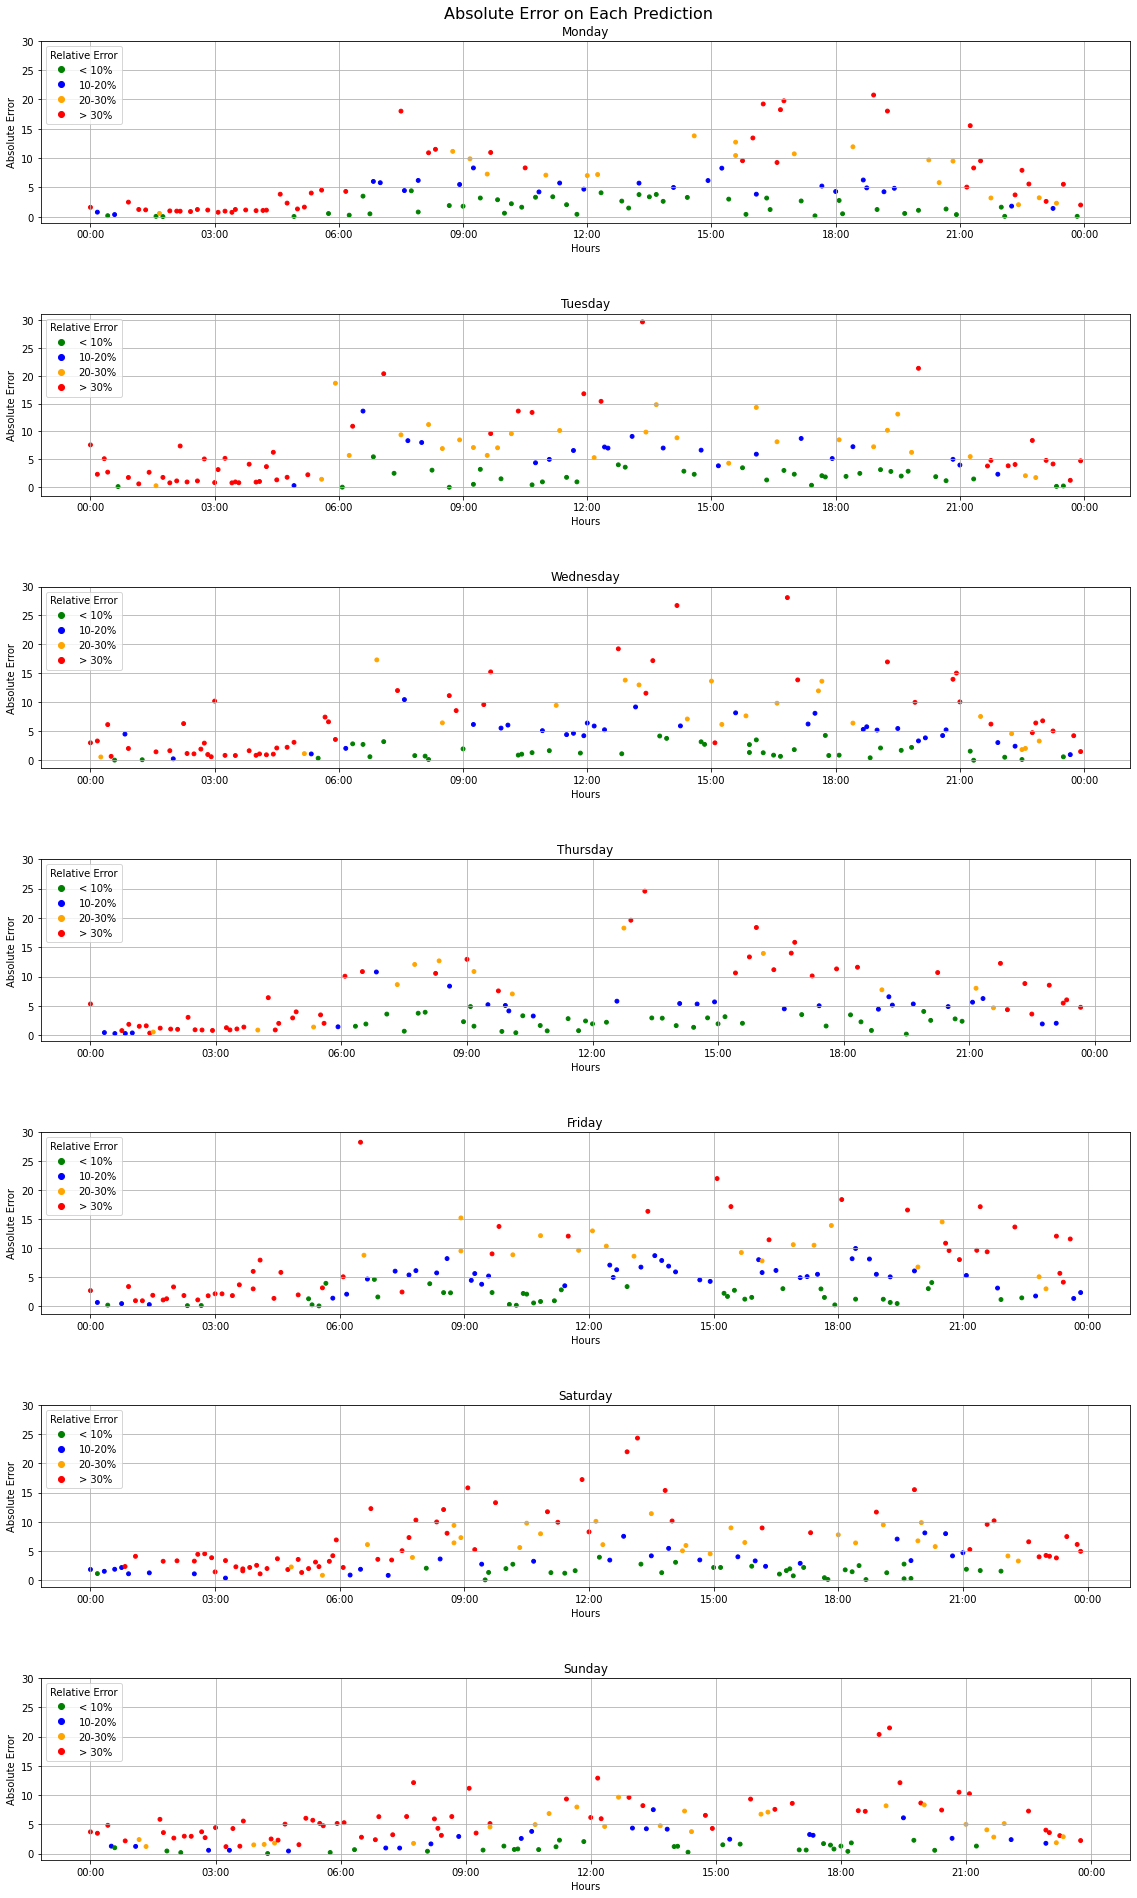

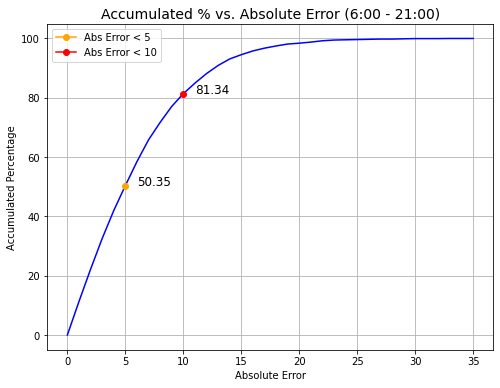

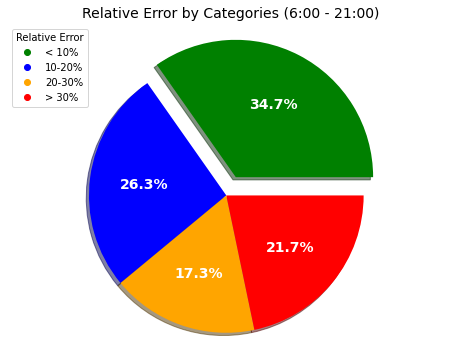

In [167]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

In [168]:
h_inicio = pd.to_timedelta('06:00:00') + pd.to_datetime('today').normalize()
h_fin = pd.to_timedelta('21:00:00') + pd.to_datetime('today').normalize()
errors.loc[ (errors['wday'] == 3) & (errors['hour'] >= h_inicio) & (errors['hour'] <= h_fin)]

,datetime,label_PM072,prediction,hour,wday,abs_error,rel_error,category
1753,2019-11-28 06:00:00,3,10.275876,2021-04-30 06:00:00,3,7.275876,2.43,> 30%
1754,2020-02-13 06:00:00,4,10.275876,2021-04-30 06:00:00,3,6.275876,1.57,> 30%
1755,2019-11-21 06:00:00,7,10.275876,2021-04-30 06:00:00,3,3.275876,0.47,> 30%
1756,2020-02-06 06:05:00,9,19.061152,2021-04-30 06:05:00,3,10.061152,1.12,> 30%
1757,2020-02-20 06:05:00,14,17.339491,2021-04-30 06:05:00,3,3.339491,0.24,20-30%
...,...,...,...,...,...,...,...,...
2067,2019-10-31 20:50:00,35,36.656239,2021-04-30 20:50:00,3,1.656239,0.05,< 10%
2068,2020-01-16 20:50:00,28,30.373642,2021-04-30 20:50:00,3,2.373642,0.08,< 10%
2069,2019-11-21 21:00:00,28,29.552240,2021-04-30 21:00:00,3,1.552240,0.06,< 10%
2070,2019-11-14 21:00:00,19,30.440474,2021-04-30 21:00:00,3,11.440474,0.60,> 30%


**NOTA:** Se puede observar que el mayor error relativo se comete por la noche, cuando menos error absoluto hay.
En la función graph_error se elimina los % > 100

In [ ]:
model.save('../saved_models/E1_MLP')

In [161]:
model = tf.keras.models.load_model('../saved_models/E1_MLP')

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #1`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente del sensor `PM029` en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #1` tiene la siguiente forma:

In [ ]:
df_1

Cada fila contiene la información temporal relevante, el valor medido por el sensor `PM029` en `t-5` y
el valor medido por `PM072` en `t`.

Ahora es necesario que cada vector de características contenga la medición realizada
por `PM029` en:
* `t-5`
* `t-10`
* `t-15`

*Además de la información horaria para cada uno de esos timesteps*

Para lograr este nuevo vector de características, en primer lugar se debe ordenar el dataset
del `Experimento #1` por el campo `datetime` (Ya debería estar, puesto que se ordenó todo el
dataset al principio y el loc de la función `prepare_df` los coge por orden y el merge resetea los index
Además, el shuffle **NO** se ha hecho *inplace*)

In [ ]:
df_1.sort_values(by='datetime', ignore_index=True, inplace=True)

Como ya se ha visto durante el `Análisis de dataset`, el dataset **NO** contiene TODAS las mediciones realizadas
durante los meses de Octubre a Febrero, por lo que no es posible coger las filas de 3 en 3.

*(En caso de hacer esto, podría darse que un vector de características tenga información de mediciones
realizadas 1 hora antes, 20 minutos antes y 5 minutos antes -> **NO SE PUEDE PERMITIR**)*

Es necesario que el dataset SOLO contenga aquellas **mediciones para las que hay mediciones en los dos
instantes temporales siguientes**.

En primer lugar se realiza una copia de `df_1` y se extraen los labels y los timesteps

In [ ]:
df_1_multi_timestep = df_1.copy(deep = True)
dates = df_1_multi_timestep.pop('datetime')
labels = df_1_multi_timestep.pop('label_PM072')

In [ ]:
df_1_multi_timestep.tail(n=6)

Ahora es necesario conocer para que timesteps existen los dos timesteps siguientes. Es decir, una medición 5 minutos
después y 10 minutos después.

In [ ]:
correct_dates_index  = []
for i in range(len(dates)-2):
    if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
        correct_dates_index.append(i)

Una vez obtenida la lista de los timesteps para los que sí hay dos mediciones consecutivas, se debe crear el vector de
características anteriormente comentado.

In [ ]:
aux_list, new_features, new_dates, new_labels = [], [], [], []
for i in correct_dates_index:
    v = df_1_multi_timestep.iloc[i:i+3].to_numpy() # Recupera 3 dilas
    new_features.append(np.append(aux_list, v)) # Une las tres filas en un array y lo añade a una lista
    new_dates.append(dates[i+2])
    new_labels.append(labels[i+2])

Finalmente, para facilitar la visualización de los datos y las operaciones posteriores que se realizarán sobre los mismos,
se ha creado un DataFrame. En este DataFrame se puede observar la fecha de la última medición de las 3 que hay en el vector
de características y la medición realizada por `PM072 5 minutos depués`

In [ ]:
df_1_multi_timestep = pd.DataFrame(new_features)
df_1_multi_timestep.insert(loc=0, column='datetime', value = new_dates)
df_1_multi_timestep.insert(loc=len(df_1_multi_timestep.columns), column='label_PM072', value = new_labels)

df_1_multi_timestep

Para condensar el proceso anterior se ha creado la siguiente función. Esta función recibe el DataFrame utilizado en la
`Implementación Perceptrón Multicapa (MLP) Simple` y devuelve el DataFrame necesario para `Implementación MLP con Múltiples Timesteps`.

In [ ]:
def prepare_multi_timestep_df(df_MLP):

    df_MLP.sort_values(by='datetime', ignore_index=True, inplace=True)

    df_multi_timestep = df_MLP.copy(deep = True)
    dates = df_multi_timestep.pop('datetime')
    labels = df_multi_timestep.pop('label_PM072')

    correct_dates_index  = []
    for i in range(len(dates)-2):
        if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
            correct_dates_index.append(i)

    aux_list, new_features, new_dates, new_labels = [], [], [], []
    for i in correct_dates_index:
        v = df_multi_timestep.iloc[i:i+3].to_numpy() # Recupera 3 filas
        new_features.append(np.append(aux_list, v)) # Une las tres filas en un array y lo añade a una lista
        new_dates.append(dates[i+2])
        new_labels.append(labels[i+2])

    df_multi_timestep = pd.DataFrame(new_features)
    df_multi_timestep.insert(loc=0, column='datetime', value = new_dates)
    df_multi_timestep.insert(loc=len(df_multi_timestep.columns), column='label_PM072', value = new_labels)

    return df_multi_timestep

#### División, Separación y Normalización

In [ ]:
# Shuffle
df_1_mts_shuffled=df_1_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_1_mts_shuffled)
train_df_1_mts = df_1_mts_shuffled[0:int(n*0.90)]
test_df_1_mts = df_1_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1_mts.pop('datetime')
test_dates = test_df_1_mts.pop('datetime')

In [ ]:
train_labels = train_df_1_mts.pop('label_PM072')
train_features = train_df_1_mts

test_labels = test_df_1_mts.pop('label_PM072')
test_features = test_df_1_mts

In [ ]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

In [ ]:
check_values = graph_predictions(test_dates, test_labels, predictions, freq = 4)

In [ ]:
FDA = check_values.loc[ (check_values['wday'] == 2) & (check_values['hour'] > '00:00') & ((check_values['hour'] < '02:10')) & (check_values['label_PM072'] > 20)]
FDA # Los valores outlayers a esta hora son el día 2020-01-01

In [ ]:
check_values.loc[ (check_values['wday'] == 2) & (check_values['hour'] > '00:00') & ((check_values['hour'] < '02:10'))]

### Implementación RNN

#### Definición RNN

Está en el fichero Arquitecturas.txt y en la Memoria

#### Implementación LSTM

En esta sección se tratará la implementación del modelo con LSTM.

Ahora mismo el dataset para el `Experimento #1` tiene las siguientes características:

In [ ]:
df_1_rnn = df_1.copy(deep = True)
df_1.sample()

Tal y como se ha comentado en `Definición RNN`, este tipo de arquitectura es capaz
de modelar el tiempo de forma explícita, por lo que ya *no es necesario* que se introduzca
la información temporal:

In [ ]:
to_drop = ['wday_sin', 'wday_cos', 'hour_sin', 'hour_cos']
df_1_rnn.drop(to_drop, axis=1, inplace=True)

Por otra parte, para que la red pueda modelar el tiempo de manera correcta, es necesario
que los datos que reciba estén ordenados temporalmente; es decir, por el campo `datetime`:

In [ ]:
df_1_rnn.sort_values(by=['datetime'], ignore_index = True , inplace = True)
df_1_rnn

El modelo LSTM aprenderá una función que sea capaz de asociar una serie de secuencias pasadas (inputs) a una
salida (output). Estas observaciones deben ser transformadas de tal manera que el modelo pueda aprender de ellas.

Para poder hacer esto el modelo necesita suficiente contexto; es decir, cada ejemplo que reciba debe contener
las mediciones realizadas en varios instantes temporales, pero siempre manteniendo el orden en el que estas
han sido tomadas. En TensorFlow, una capa de tipo LSTM requiere una entrada con 3D la siguiente forma **[samples, timesteps, features]:**
* *samples*: Número de ejemplos
* *timesteps*: El número de instantes temporales que contiene cada ejemplo
* *features*: El número de características del dataset

**EN LA MEMORIA PONER UN DIBUJO DE COMO ES LA ENTRADA 3D**

Se ha considerado que el **número de timesteps a usar será 3**. Es decir, cada ejemplo cuenta con la información tomada por
los sensores a utilizar en cada Experimento en el instante `t-5, t-10 y t-15`. A partir de esta información, el modelo
tratará de predecir el número de coches que pasarán por el sensor `PM072` en el instante `t`.

Antes de crear esta entrada 3D es necesario normalizar y dividir el conjunto

#### División del dataset, Separación y Normalización

Cabe destacar que ahora, al utilizar una RNN (LSTM) NO se debe hacer el shuffle que
se hizo previamente al trabajar con el MLP.

In [ ]:
n = len(df_1_rnn)
train_df_1_rnn = df_1_rnn[0:int(n*0.90)]
test_df_1_rnn = df_1_rnn[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1_rnn.pop('datetime')
test_dates = test_df_1_rnn.pop('datetime')

In [ ]:
train_labels = train_df_1_rnn.pop('label_PM072')
train_features = train_df_1_rnn

test_labels = test_df_1_rnn.pop('label_PM072')
test_features = test_df_1_rnn

In [ ]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

##### Entrada celda LSTM

Ahora que se ha realizado todo el proceso anterior, ya es posible crear la entrada 3D. Pero antes, se debe tener en cuenta que,
al igual que se ha visto en la sección `Implementación MLP con Múltiples Timesteps`, el dataset no presenta TODAS las mediciones.

El modelo debe recibir la información de los instantes `t-5, t-10 y t-15`. Para ello, es necesario seleccionar solo
aquellas filas para las que hay dos mediciones en los dos instantes temporales posteriores. **Esas mediciones en esos
3 instantes será la entrada 3D del modelo.**

Asimismo, se deben almacenar solo los labels y fechas correspondientes a la medición en el instante `t-5`

Para ello se ha creado la siguiente función, la cual recibe como parámetros todas las `features` y sus `labels`
correspondientes. Devuelve la entrada LSTM en 3D, el`label` y `datetime` correspondiente a cada ejemplo de `3 timesteps`:

In [ ]:
def create_LSTM_data(input, output, dates):

    # Necesario el reset para acceder por index
    input.reset_index(inplace=True, drop=True)
    output.reset_index(inplace=True, drop=True)
    dates.reset_index(inplace=True, drop=True)

    # Mediciones para las que hay dos mediciones posteriores
    correct_dates_index  = []
    for i in range(len(dates)-2):
        if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
            correct_dates_index.append(i)

    Xs, ys, dts = [], [], []
    for i in correct_dates_index:
        v = input.iloc[i:i+3].to_numpy() # Recupera 3 filas
        Xs.append(v)
        ys.append(output[i+2])
        dts.append(dates[i+2])

    return np.array(Xs), np.array(ys), np.array(dts)

In [ ]:
train_features

In [ ]:
train_labels

In [ ]:
train_inputs, train_outputs, train_dates = create_LSTM_data(train_features, train_labels, train_dates)
test_inputs, test_outputs, test_dates = create_LSTM_data(test_features, test_labels, test_dates)

print('train_inputs.shape: ', train_inputs.shape)
print('train_outputs.shape: ', train_outputs.shape)
print('test_inputs.shape: ', test_inputs.shape)
print('test_outputs.shape: ', test_outputs.shape)

In [ ]:
train_inputs

In [ ]:
train_outputs

Como se puede observar, cada ejemplo tiene las mediciones correspondientes a `3 instantes temporales` y tiene
asociada la medición realizada por el sensor `PM072` en el último instante temporal. **En realidad, el valor
de la medición del sensor `PM072` de cada fila corresponde a la medición realiza 5 minutos después de las
mediciones de los otros sensores de la fila!!. Esto ya se ha explicado al principio**

Ahora que ya se ha obtenido una entrada y salida adecuadas, ya es posible comenzar con el entrenamiento.

#### Entrenamiento

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.LSTM(64,
                   activation='relu', return_sequences=True,
                   input_shape=(train_inputs.shape[1], train_inputs.shape[2]) ),
      layers.LSTM(64, return_sequences=True,
                   activation='relu'),
      layers.LSTM(64,
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_inputs,
    train_outputs,
    validation_split=0.1,
    verbose=0,
    shuffle = False,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_inputs), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_inputs, test_outputs, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)

## Experimento #2

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #2** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
- `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
- `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
- `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
* **No es posible, ya que es sensor estaba averiado** - `PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

### Análisis dataset Experimento #2

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [ ]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032', 'PM072']
df_2 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [ ]:
df_2.describe().transpose()

Veamos un boxplot:

In [ ]:
df_2.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`

### Análisis gráfico Experimento #2

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

Para determinar si la medición en la que se registró el mayor valor para `car_count` es un outlayer se puede
representar la evolución de ese día y de otros.

In [ ]:
df_2.loc[df_2['car_count'] > 100]

In [ ]:
days = pd.date_range(start='2019-12-12', end='2019-12-14', freq='D')
plot_sensors_daily_data(df_orig=df_2, days_list = days, sensor='PM024')

En la gráfica correspondiente al `2019-12-17` se puede observar lo comentado en el anterior experimento. Los sensores
pueden fallar (o no realizar mediciones por labores de mantenimiento), por lo que, en caso de que esto suceda, **las mediciones
de los otros sensores que fueron realizados en ese mismo instante temporal deben ser descartadas.**

*De esto ya se encarga la función que ha sido creada para preparar el dataset.*

Por otra parte, la gráfica correspondiente `2019-12-18`, el día en el que se registró el máximo valor de `car_count`, se
puede observar un pico muy pronunciado. Para tener más claro si se trata de un error en la medición se pueden observar las
mediciones previas y posteriores a ese instante temporal para el sensor `PM032`:

In [ ]:
df_2.loc[(df_2['datetime'] >= '2019-12-18 10:30:00') & (df_2['datetime'] <= '2019-12-18 11:00:00') & (df_2['sensor'] == 'PM032')]

Observando las mediciones anteriores y posteriores se puede observar que no hay entradas para los 10 minutos anteriores.
**En ocasiones, los sensores se detienen o fallan y al recuperarse insertan como medición el total de coches que pasaron
durante esos minutos que estuvieron fuera de servicio. Este valor es el resultado de un error, por lo que la medición debe
ser eliminada:**

In [ ]:
df_2 = df_2[df_2['car_count'] < 100.0]

Para determinar si alguna de las mediciones con mayor cuantía de vehículos (> 90) se trataba de un error se ha seguido un
procedimiento similar. **Finalmente, se ha determinado que ninguna de esas mediciones se trata de un error.**

### Preparación dataset Experimento #2

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [ ]:
column_names = ['datetime', 'car_count_PM024', 'car_count_PM030', 'car_count_PM031', 'car_count_PM032', 'label_PM072']
pd.DataFrame(columns = column_names)

A continuación se utiliza la función para preparar el dataset para el Experimento #2:

In [ ]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032']
df_2 = prepare_df(df_2, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función que en el Experimento #1:

In [ ]:
df_2 = encode_time_sin_cos(df_2)
df_2.sample()

### Implementación Perceptrón Multicapa (MLP)

#### División del dataset, Separación y Normalización

In [ ]:
#Shuffle
df_2_shuffled=df_2.sample(frac=1).reset_index(drop=True)

n = len(df_2_shuffled)
train_df_2 = df_2_shuffled[0:int(n*0.90)]
test_df_2 = df_2_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_2.pop('datetime')
test_dates = test_df_2.pop('datetime')

In [ ]:
train_labels = train_df_2.pop('label_PM072')
train_features = train_df_2

test_labels = test_df_2.pop('label_PM072')
test_features = test_df_2

In [ ]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
mae

In [ ]:
graph_predictions(test_dates, test_labels, predictions, freq = 4)

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #2`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente de los sensores `PM024, PM030, PM031 y PM032` en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #2` tiene la siguiente forma:

In [ ]:
df_2

Utilizando la función anteriormente definida se creará el DataFrama con la información necesaria para el Experimento:

In [ ]:
df_2_multi_timestep = prepare_multi_timestep_df(df_2)
df_2_multi_timestep

#### División, Separación y Normalización

In [ ]:
# Shuffle
df_2_mts_shuffled=df_2_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_2_mts_shuffled)
train_df_2_mts = df_2_mts_shuffled[0:int(n*0.90)]
test_df_2_mts = df_2_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_2_mts.pop('datetime')
test_dates = test_df_2_mts.pop('datetime')

In [ ]:
train_labels = train_df_2_mts.pop('label_PM072')
train_features = train_df_2_mts

test_labels = test_df_2_mts.pop('label_PM072')
test_features = test_df_2_mts

In [ ]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(16,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

## Experimento #3

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #3** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
- `PM076` (Rúa do Horreo - Rotonda Galuresa)
- `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
- `PM079` (Rúa do Horreo - Rotonda Galuresa)

### Análisis dataset Experimento #3

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [ ]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079', 'PM072']
df_3 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [ ]:
df_3.describe().transpose()

Veamos un boxplot:

In [ ]:
df_3.boxplot(column=['car_count'])

En este boxplot se pueden ver 3 outalyers muy claros. En la siguiente sección se determinará la causa de dichos valores.

### Análisis gráfico Experimento #3

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

A continuación se analizarán las mediciones 'sospechosas' del boxplot anterior:

In [ ]:
df_3.loc[df_3['car_count'] > 100]

Resulta interesante ver que las 3 mediciones se produjeron en el mismo instante temporal.

En la siguiente gráfica se muestra la evolución del día anterior y siguiente al `2019-11-22` para el
sensor `PM079`:

In [ ]:
days = pd.date_range(start='2019-11-21', end='2019-11-23', freq='D')
plot_sensors_daily_data(df_orig=df_3, days_list = days, sensor='PM079')

En la gráfica correspondiente al `2019-11-22` se puede observar lo comentado en el anterior experimento. Al tratarse de
un error en las mediciones estos datos deben ser eliminados del conjunto:

In [ ]:
df_3 = df_3[df_3['car_count'] < 100]

El resto de mediciones se encuentran dentro de lo normal

### Preparación dataset Experimento #3

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [ ]:
column_names = ['datetime', 'car_count_PM020', 'car_count_PM076', 'car_count_PM077', 'car_count_PM079', 'label_PM072']
pd.DataFrame(columns = column_names)

A continuación se utiliza la función para preparar el dataset para el Experimento #3:

In [ ]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079']
df_3 = prepare_df(df_3, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:

In [ ]:
df_3 = encode_time_sin_cos(df_3)
df_3.sample()

### Implementación Perceptrón Multicapa (MLP)

#### División del dataset, Separación y Normalización

In [ ]:
#Shuffle
df_3_shuffled=df_3.sample(frac=1).reset_index(drop=True)

n = len(df_3_shuffled)
train_df_3 = df_3_shuffled[0:int(n*0.90)]
test_df_3 = df_3_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_3.pop('datetime')
test_dates = test_df_3.pop('datetime')

In [ ]:
train_labels = train_df_3.pop('label_PM072')
train_features = train_df_3

test_labels = test_df_3.pop('label_PM072')
test_features = test_df_3

In [ ]:
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dropout(0.2),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
mae

In [ ]:
graph_predictions(test_dates, test_labels, predictions, freq = 4)

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #3`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente de los sensores `PM020, PM076, PM077 y PM079` en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #3` tiene la siguiente forma:

In [ ]:
df_3

Utilizando la función anteriormente definida se creará el DataFrama con la información necesaria para el Experimento:

In [ ]:
df_3_multi_timestep = prepare_multi_timestep_df(df_3)
df_3_multi_timestep

#### División, Separación y Normalización

In [ ]:
# Shuffle
df_3_mts_shuffled=df_3_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_3_mts_shuffled)
train_df_3_mts = df_3_mts_shuffled[0:int(n*0.90)]
test_df_3_mts = df_3_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_3_mts.pop('datetime')
test_dates = test_df_3_mts.pop('datetime')

In [ ]:
train_labels = train_df_3_mts.pop('label_PM072')
train_features = train_df_3_mts

test_labels = test_df_3_mts.pop('label_PM072')
test_features = test_df_3_mts

In [ ]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=100
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

## Experimento #4

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #4** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t a partir de
las mediciones realizadas en un instante `t-x` por **todos los sensores de la ciudad.**

### Análisis dataset Experimento #4

En este caso se trabaja con todo el dataset, por lo que no es necesario especificar los sensores en concreto:

In [ ]:
df_4 = df

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [ ]:
df_4.describe().transpose()

Veamos un boxplot:

In [ ]:
df_4.boxplot(column=['car_count'])

En este boxplot se puede observar que hay una gran cantidad de mediciones que superan los 100 coches en 5 minutos.
Debido a la gran cantidad de mediciones que hay (en torno a 3 millones), resulta imposible realizar un análisis gráfico
como se realizó para los experimentos anteriores.

Por lo experiencia obtenida durante los anteriores experimentos y aplicando
un poco de lógica, se descartarán todas las mediciones que superen un `car_count de 200`. Esto se debe a que en los experimentos
anteriores se pudo concluir que eran outlayers debidos a errores o fallos en el funcionamiento de los sensores. Por otra parte,
un `car_count de 200` implica un flujo de 40 coches por minuto, lo cual en una ciudad como Santiago de Compostela es bastante.
Asimismo, todos los sensores están colocados en vías urbanas en las que hay tan sólo un carril y la velocidad está limitada
a 50km/h (como máximo), por lo que aplicando un poco de sentido común, es imposible que pasen 40 coches por minuto de media.

In [ ]:
df_4 = df_4.loc[df_4['car_count'] < 200]

### Preparación dataset Experimento #4

#### Label PM072

A continuación se utiliza la función para preparar el dataset para el Experimento #4:

In [ ]:
# Selecciono todos los nombres de sensores (sin repetición)
sensors_list = df_4['sensor'].unique()
# PM072 será el label
sensors_list = np.delete(sensors_list,np.where(sensors_list == 'PM072'))
# Los ordeno por comodidad
sensors_list.sort()
# Preparo el dataset
df_4 = prepare_df(df_4, sensors_list, 'PM072', x = 5)

A partir de la experiencia obtenida en los anteriores experimentos, sabemos que hay sensores que nunca contaron un coche;
es decir, su columna en este nuevo dataframe es todo 0. Como estos datos no aportan nada, dichas columnas deben ser eliminadas:

In [ ]:
df_4 = df_4.loc[:, (df_4 != 0).any(axis=0)]

Además, se ha podido observar que algunas columnas tan solo tienen un par de datos distintos de 0; es decir, tan
solo han realizado 2 mediciones de las 36790. Estas columnas también deben ser eliminadas

In [ ]:
xx = df_4.loc[:, df_4.columns != 'datetime']
aa = xx.astype(bool).sum(axis=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(aa)

En esta lista se puede observar que los sensores `PM009`, `PM061`, `PM074` y `PM075` solo han realizado
2 mediciones a lo largo de estos 5 meses.

In [ ]:
to_drop = ['car_count_PM009', 'car_count_PM061', 'car_count_PM074', 'car_count_PM075']
df_4 = df_4.drop(to_drop, axis=1)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:

In [ ]:
df_4 = encode_time_sin_cos(df_4)
df_4.sample()

### Implementación Perceptrón Multicapa (MLP)

#### División del dataset, Separación y Normalización

In [ ]:
#Shuffle
df_4_shuffled=df_4.sample(frac=1).reset_index(drop=True)

n = len(df_4_shuffled)
train_df_4 = df_4_shuffled[0:int(n*0.90)]
test_df_4 = df_4_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4.pop('datetime')
test_dates = test_df_4.pop('datetime')

In [ ]:
train_labels = train_df_4.pop('label_PM072')
train_features = train_df_4

test_labels = test_df_4.pop('label_PM072')
test_features = test_df_4

In [ ]:
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(32,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(16,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(8,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
mae

In [ ]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #4`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente de todos los sensores disponibles en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #4` tiene la siguiente forma:

In [ ]:
df_4

Utilizando la función anteriormente definida se creará el DataFrama con la información necesaria para el Experimento:

In [ ]:
df_4_multi_timestep = df_4.copy(deep = True)
df_4_multi_timestep = prepare_multi_timestep_df(df_4_multi_timestep)
df_4_multi_timestep

#### División, Separación y Normalización

In [ ]:
# Shuffle
df_4_mts_shuffled=df_4_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_4_mts_shuffled)
train_df_4_mts = df_4_mts_shuffled[0:int(n*0.90)]
test_df_4_mts = df_4_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4_mts.pop('datetime')
test_dates = test_df_4_mts.pop('datetime')

In [ ]:
train_labels = train_df_4_mts.pop('label_PM072')
train_features = train_df_4_mts

test_labels = test_df_4_mts.pop('label_PM072')
test_features = test_df_4_mts

In [ ]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [ ]:
train_features

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

In [ ]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

### Implementación Ree Neuronal Convolucional (CNN)

Como ya se ha comentado anteriormente, las CNN se utilizan principalmente cuando se trabaja
con imágenes; sin embargo, también es posible utilizarlas para problemas de regresión con series
temporales. La CNN tendrá que aprender una función que sea capaz de mapear una secuencia de
observaciones pasadas a una determinada salida; es decir, realizará la convolución (y demás operaciones)
sobre una entrada unidimensional.

Partiendo del df creado para la experimentación con MLP:

In [ ]:
df_4_cnn = df_4.copy(deep = True)
df_4.sample()

Las CNN utilizadas cuando se trabaja con imágenes se conocen como CNN bidimensionales. En este trabajo, al tratar con
series temporales se utilizan las CNN unidimensionales, las cuales son capaces de extraer información a lo largo de
la dimensión del tiempo (por eso son 1D). Esto implica que el kernel o filtro utilizado para la convolución se desplazará
tan solo en un sentido, tal y como se muestra la Figura, a diferencia de lo que ocurre en la convolución de una imagen.
Este kernel tendrá el mismo número de columnas que características tenga el ejemplo y tantas filas como instantes temporales
deseemos utilizar.

Por todo esto la información que se le proporcione a la red debe estar ordenada cronológicamente.



In [ ]:
#to_drop = ['wday_sin', 'wday_cos', 'hour_sin', 'hour_cos']
#df_4_cnn.drop(to_drop, axis=1, inplace=True)


df_4_cnn.sort_values(by=['datetime'], ignore_index = True , inplace = True)
df_4_cnn

#### División del dataset, Separación y Normalización

Cabe destacar que ahora, al utilizar una RNN (LSTM) NO se debe hacer el shuffle que
se hizo previamente al trabajar con el MLP.

In [ ]:
n = len(df_4_cnn)
train_df_4_cnn = df_4_cnn[0:int(n*0.90)]
test_df_4_cnn = df_4_cnn[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4_cnn.pop('datetime')
test_dates = test_df_4_cnn.pop('datetime')

In [ ]:
train_labels = train_df_4_cnn.pop('label_PM072')
train_features = train_df_4_cnn

test_labels = test_df_4_cnn.pop('label_PM072')
test_features = test_df_4_cnn

In [ ]:
# Esto es ESTANDARIZACIÓN
#train_mean = train_features.mean()
#train_std = train_features.std()

#train_features = (train_features - train_mean) / train_std
#test_features = (test_features - train_mean) / train_std

In [ ]:
# Esto es NORMALIZACION

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(train_features)

# Apply the scaler to training data
train_features = input_scaler.transform(train_features)

# Apply the scaler to test data
test_features = input_scaler.transform(test_features)

##### Entrada CNN

Ahora es el momento en el que se crearán los ejemplos con los instantes temporales, pero antes se debe tener en cuenta que,
al igual que se ha visto en la sección `Implementación MLP con Múltiples Timesteps`, el dataset no presenta TODAS las mediciones.
Cada entrada tendrá la información de los instantes `t-15, t-10 y t-5` y la salida será el valor medido por `PM072`
en el instante `t`. Para ello, es necesario seleccionar solo aquellas filas para las que hay dos mediciones en los dos
instantes temporales posteriores. **Esas mediciones en esos 3 instantes será la entrada del modelo.**

(La fecha almacenada corresponde al último timestep de cada ejemplo; es decir, `t-5`)

In [ ]:
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features

In [ ]:
train_labels

In [ ]:
def create_CNN_data(input, output, dates):

    # Necesario el reset para acceder por index
    input.reset_index(inplace=True, drop=True)
    output.reset_index(inplace=True, drop=True)
    dates.reset_index(inplace=True, drop=True)

    # Mediciones para las que hay dos mediciones posteriores
    correct_dates_index  = []
    for i in range(len(dates)-2):
        if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
            correct_dates_index.append(i)

    Xs, ys, dts = [], [], []
    for i in correct_dates_index:
        v = input.iloc[i:i+3].to_numpy() # Recupera 3 filas
        Xs.append(v)
        ys.append(output[i+2])
        dts.append(dates[i+2])

    return np.array(Xs), np.array(ys), np.array(dts)

In [ ]:
train_inputs, train_outputs, train_dates = create_CNN_data(train_features, train_labels, train_dates)
test_inputs, test_outputs, test_dates = create_CNN_data(test_features, test_labels, test_dates)

print('train_inputs.shape: ', train_inputs.shape)
print('train_outputs.shape: ', train_outputs.shape)
print('test_inputs.shape: ', test_inputs.shape)
print('test_outputs.shape: ', test_outputs.shape)

In [ ]:
train_inputs

In [ ]:
train_outputs

Como se puede observar, cada ejemplo tiene las mediciones correspondientes a `3 instantes temporales` y tiene
asociada la medición realizada por el sensor `PM072` en el último instante temporal.

#### Entrenamiento

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Conv1D(filters=256,
                     kernel_size=3,  activation='relu',
                     input_shape=(train_inputs.shape[1], train_inputs.shape[2]) ),
      layers.MaxPooling1D(pool_size=1),
      layers.Flatten(),
      layers.Dense(50, activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model


In [ ]:
model = build_and_compile_model()
model.summary()

In [ ]:
%%time
history = model.fit(
    train_inputs,
    train_outputs,
    validation_split=0.1,
    verbose=0,
    shuffle = False,
    callbacks=get_callbacks(),
    batch_size=64,
    epochs=200
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_inputs), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_inputs, test_outputs, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)

In [ ]:
errors = graph_errors(pd.DataFrame(test_dates, columns= ['datetime']), pd.DataFrame(test_outputs,  columns= ['label_PM072']), predictions, freq = 4)

### Implementación RNN

#### Implementación LSTM

En esta sección se tratará la implementación del modelo con LSTM.

Ahora mismo el dataset para el `Experimento #4` tiene las siguientes características:

In [ ]:
df_4_rnn = df_4.copy(deep = True)
df_4.sample()

Tal y como se ha comentado en `Definición RNN`, este tipo de arquitectura es capaz
de modelar el tiempo de forma explícita, por lo que ya *no es necesario* que se introduzca
la información temporal:

In [ ]:
to_drop = ['wday_sin', 'wday_cos', 'hour_sin', 'hour_cos']
df_4_rnn.drop(to_drop, axis=1, inplace=True)

Por otra parte, para que la red pueda modelar el tiempo de manera correcta, es necesario
que los datos que reciba estén ordenados temporalmente; es decir, por el campo `datetime`:

In [ ]:
df_4_rnn.sort_values(by=['datetime'], ignore_index = True , inplace = True)
df_4_rnn

#### División del dataset, Separación y Normalización

Cabe destacar que ahora, al utilizar una RNN (LSTM) NO se debe hacer el shuffle que
se hizo previamente al trabajar con el MLP.

In [ ]:
n = len(df_4_rnn)
train_df_4_rnn = df_4_rnn[0:int(n*0.90)]
test_df_4_rnn = df_4_rnn[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4_rnn.pop('datetime')
test_dates = test_df_4_rnn.pop('datetime')

In [ ]:
train_labels = train_df_4_rnn.pop('label_PM072')
train_features = train_df_4_rnn

test_labels = test_df_4_rnn.pop('label_PM072')
test_features = test_df_4_rnn

In [ ]:
# Esto es ESTANDARIZACIÓN
#train_mean = train_features.mean()
#train_std = train_features.std()

#train_features = (train_features - train_mean) / train_std
#test_features = (test_features - train_mean) / train_std

In [ ]:
# Esto es NORMALIZACION

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(train_features)

# Apply the scaler to training data
train_features = input_scaler.transform(train_features)

# Apply the scaler to test data
test_features = input_scaler.transform(test_features)

##### Entrada celda LSTM

Ahora que se ha realizado todo el proceso anterior, ya es posible crear la entrada 3D. Pero antes, se debe tener en cuenta que,
al igual que se ha visto en la sección `Implementación MLP con Múltiples Timesteps`, el dataset no presenta TODAS las mediciones.

El modelo debe recibir la información de los instantes `t-15, t-10 y t-5` y la salida será el valor medido por `PM072`
en el instante `t`. Para ello, es necesario seleccionar solo aquellas filas para las que hay dos mediciones en los dos
instantes temporales posteriores. **Esas mediciones en esos 3 instantes será la entrada 3D del modelo.**

(La fecha almacenada corresponde al último timestep de cada ejemplo; es decir, `t-5`)

In [ ]:
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features

In [ ]:
train_labels

In [ ]:
train_inputs, train_outputs, train_dates = create_LSTM_data(train_features, train_labels, train_dates)
test_inputs, test_outputs, test_dates = create_LSTM_data(test_features, test_labels, test_dates)

print('train_inputs.shape: ', train_inputs.shape)
print('train_outputs.shape: ', train_outputs.shape)
print('test_inputs.shape: ', test_inputs.shape)
print('test_outputs.shape: ', test_outputs.shape)

In [ ]:
train_inputs

In [ ]:
train_outputs

Como se puede observar, cada ejemplo tiene las mediciones correspondientes a `3 instantes temporales` y tiene
asociada la medición realizada por el sensor `PM072` en el último instante temporal.

#### Entrenamiento

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.LSTM(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', return_sequences=True,
                   input_shape=(train_inputs.shape[1], train_inputs.shape[2]) ),
      layers.Dropout(0.2),
      layers.LSTM(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', return_sequences=True ),
      layers.Dropout(0.2),
      layers.LSTM(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', return_sequences=False ),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model


In [ ]:
model = build_and_compile_model()
model.summary()


¡Se indica la opción `shuffle = False` para que no haga un shuffle del conjunto de entrenamiento antes de cada época!
De esta manera se asegura que la información se introduce en orden cronológico

In [ ]:
%%time
history = model.fit(
    train_inputs,
    train_outputs,
    validation_split=0.1,
    verbose=0,
    shuffle = False,
    callbacks=get_callbacks(),
    batch_size=64,
    epochs=300
)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [ ]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_inputs), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_inputs, test_outputs, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)

In [ ]:
errors = graph_errors(pd.DataFrame(test_dates, columns= ['datetime']), pd.DataFrame(test_outputs,  columns= ['label_PM072']), predictions, freq = 4)

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return np.tanh(x)

def RELU(x):
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)
    return x1

In [ ]:
x = np.linspace(-2, 2)
plt.plot(x, sigmoid(x), label="Sigmoid")
plt.plot(x, tanh(x),  label="Tanh")
plt.plot(x, RELU(x),  label="ReLu")
plt.axis('tight')
plt.xlabel("Entrada")
plt.ylabel("Salida")
plt.legend(loc="upper left")
plt.savefig('../img/activations.png', bbox_inches='tight', transparent=True)